In [2]:


import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes

from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
#%matplotlib notebook
from astrodendro.analysis import PPVStatistic
from astrodendro.analysis import PPStatistic
from matplotlib.patches import Ellipse
#%matplotlib widget

astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16


Clean Notebook for NGC253

Featuring:

HCO+ 4-3
HCN 4-3
H13CN 4-3

HCN_J1-0
HCO+_J1-0
H13CO+_J1-0_and_SiO_J2-1
H13CN_J1-0
CO_J3-2

CCH_N1-0
HC3NJ11-10

Part 1: Updates

Part 2: File Reads, Integrated Maps

Part 3: Image Ratios

Part 4: Channel Maps

Part 5: PV Plots

Part 6: Reporojection

Part 7: Spectra

Part 8: Dendograms

# Part 1: Updates

In [2]:
'''
!pip install git+https://github.com/astropy/astropy
!pip install reproject
!pip install git+https://github.com/radio-astro-tools/spectral-cube.git
!pip install pyspeckit
!pip install regions
!pip install astrodendro
!pip install wcsaxes
!pip install ipympl


!pip install spectral_cube
!pip install typing
!pip install mypy
!pip install typing_extensions
'''

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 22.8 MB 78 kB/s s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [37]:
path = 'NGC253.HCO+_4-3.pbcor.fits'

#path = "HC3N_11_10.fits"

scP = SpectralCube.read(path)
sc = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = sc.wcs[:][:][0]

raDP1 = scW.pixel_to_world(0,0)
raDP2 = scW.pixel_to_world(1,1)

a=(raDP1)
b=(raDP2)
print(a)
print(b)

vel,NA,na = sc.world[:,0,0]

#too accurate?
#50 mili arcseconds

header5 = sc.header
beam5_a = header5["BMAJ"]*3600.0 # beam sizes in arcseconds
beam5_b = header5["BMIN"]*3600.0
pixel5 = header5["CDELT1"] * (-1)*3600.0

#print(sc.statistics())
print(header5)

print(abs(header5["CDELT3"]))

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (11.89569316, -25.29536925)>
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (11.8956778, -25.29535536)>


AttributeError: 'SpectralCube' object has no attribute 'statistics'

# Part 2: File Reads, Moment Maps

24.716984243444173


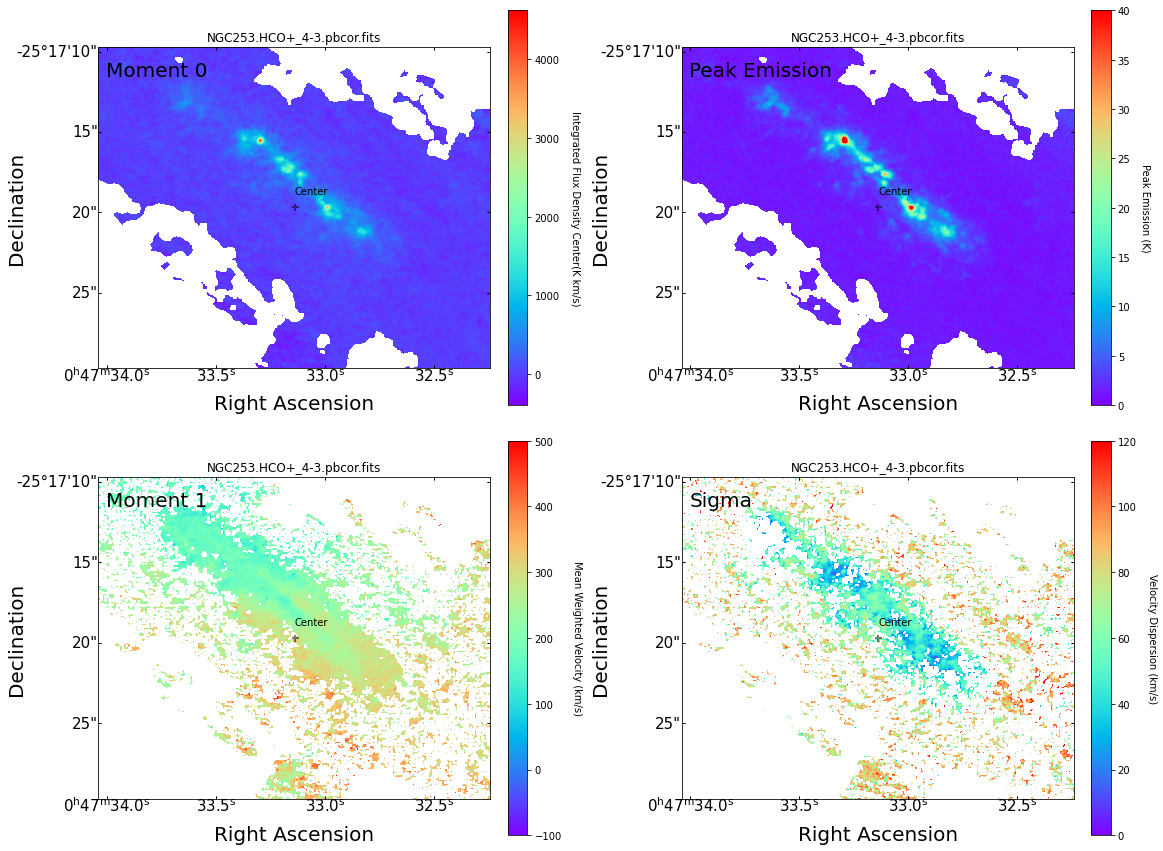

In [5]:
#HCO+ 4-3

path = 'NGC253.HCO+_4-3.pbcor.fits'

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True


#Remove Non-zoomed images !
#Remove vmin vmax !
#Make vmin vmax for moment 1, simga !
#Make spectral slab ~100-500 km/s !
#Try to show where the center is (find from a paper) !
#Fix padding ?
#Same raneg for each molecule !
#Mask ratios under a certain value (rainbow?) !
#Consistent vmin vmax for all channels (log scaling?) !
#More channels in the maps !
#Make HCN/H13CN !
#Fix Labels !
#REdefine velocity axis using spectral cube, based on rest frequency !


###### Make zoomed in images
# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')
#Infrared Center: 00 47 33.134 -25 17 19.68 . Ref: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NGC+++253


cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
sc = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


subcube = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube


subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 


#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[0:int(len(sc)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]].moment(order=0,how='slice') # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()/u.K/u.km*u.s

print(m1)

badpixS = pylab.where(abs(moment_0_sub.hdu.data)<m1*1)                 # Get ready to mask the data based on moment map
moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(2,2,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax4 = pylab.subplot(2,2,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow',vmin=0,vmax=40)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak Emission (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(2,2,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',vmin=-100,vmax=500)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax8 = pylab.subplot(2,2,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow',vmin=0,vmax=120)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=-10)

ax3.set_title("NGC253.HCO+_4-3.pbcor.fits")
ax4.set_title("NGC253.HCO+_4-3.pbcor.fits")
ax7.set_title("NGC253.HCO+_4-3.pbcor.fits")
ax8.set_title("NGC253.HCO+_4-3.pbcor.fits")

fig1.savefig(bbox_inches='tight',fname="NGC253_HCO+_4-3_Integrated_Full_Note.jpeg")



22.6744348696535


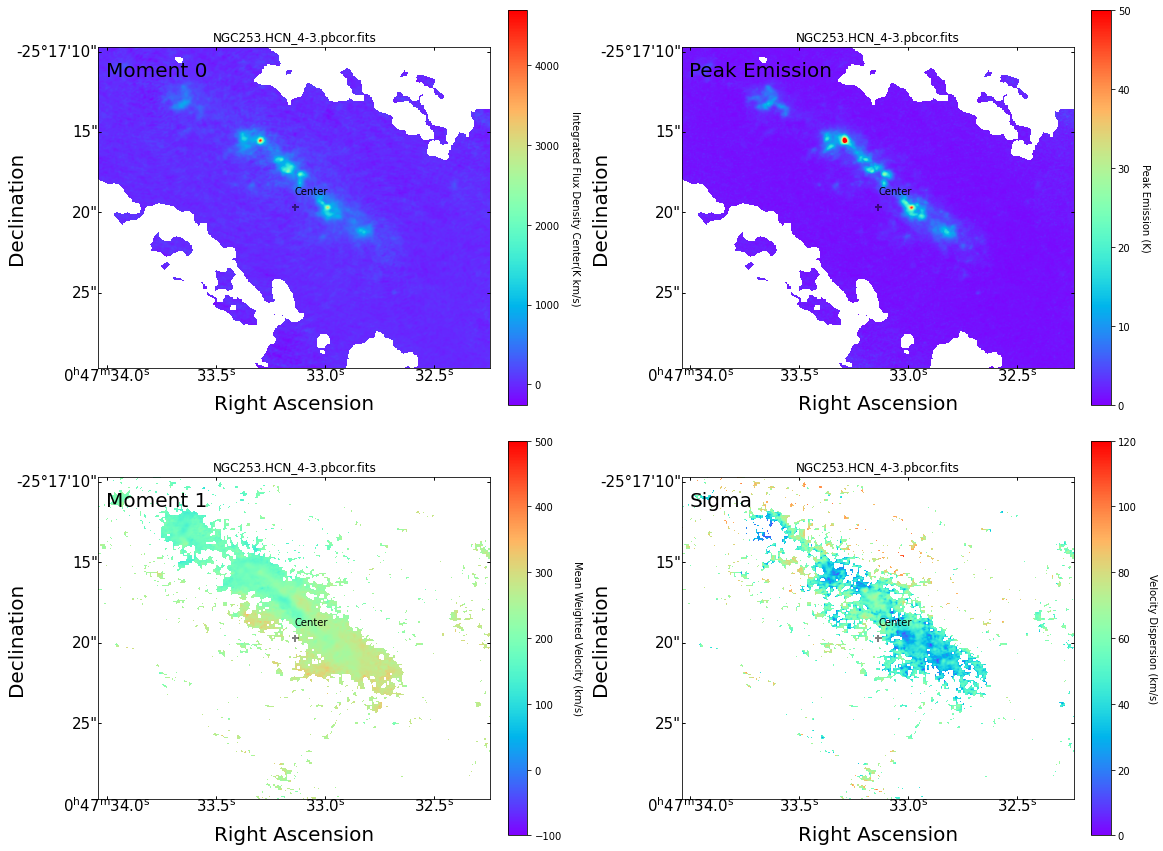

In [4]:
#HCN 4-3


path = 'NGC253.HCN_4-3.pbcor.fits'

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True

# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')


cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
sc = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = sc.wcs[:][:][0]


raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


subcube = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[0:int(len(sc)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]].moment(order=0,how='slice') # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()/u.K/u.km*u.s

print(m1)



badpixS = pylab.where(abs(moment_0_sub.hdu.data)<m1*3)                 # Get ready to mask the data based on moment map

moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(2,2,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax4 = pylab.subplot(2,2,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow',vmin=0,vmax=50)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak Emission (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(2,2,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',vmin=-100,vmax=500)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax8 = pylab.subplot(2,2,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow',vmin=0,vmax=120)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=-10)


ax3.set_title("NGC253.HCN_4-3.pbcor.fits")
ax4.set_title("NGC253.HCN_4-3.pbcor.fits")
ax7.set_title("NGC253.HCN_4-3.pbcor.fits")
ax8.set_title("NGC253.HCN_4-3.pbcor.fits")

fig1.savefig(bbox_inches='tight',fname="NGC253.HCN_4-3_Integrated_Full_Note.jpeg")




In [ ]:
#H13CN 4-3




path = 'NGC253.H13CN_4-3.pbcor.fits'

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True

# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')


cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
sc = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = sc.wcs[:][:][0]


raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


subcube = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[0:int(len(sc)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]].moment(order=0,how='slice') # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()/u.K/u.km*u.s

print(m1)



badpixS = pylab.where(abs(moment_0_sub.hdu.data)<m1*2)                 # Get ready to mask the data based on moment map

moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(2,2,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax4 = pylab.subplot(2,2,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow',vmin=0,vmax=40)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak Emission (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(2,2,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',vmin=-100,vmax=500)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax8 = pylab.subplot(2,2,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow',vmin=0,vmax=120)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=-10)


ax3.set_title("NGC253.H13CN_4-3.pbcor.fits")
ax4.set_title("NGC253.H13CN_4-3.pbcor.fits")
ax7.set_title("NGC253.H13CN_4-3.pbcor.fits")
ax8.set_title("NGC253.H13CN_4-3.pbcor.fits")

fig1.savefig(bbox_inches='tight',fname="NGC253.H13CN_4-3_Integrated_Full_Note.jpeg")

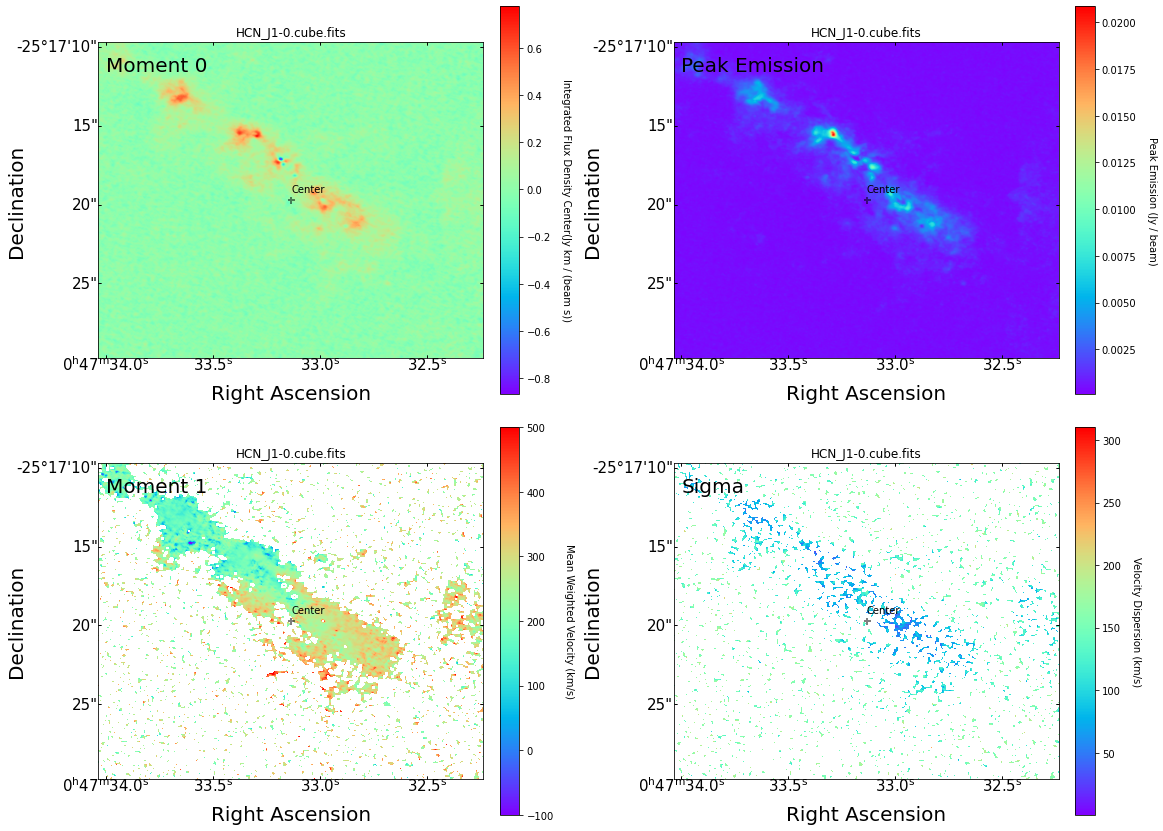

In [6]:
#HCN_J1-0

path = 'HCN_J1-0.cube.fits'

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True

# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')


cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
sc = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = sc.wcs[:][:][0]


raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


subcube = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[0:int(len(sc)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]].moment(order=0,how='slice') # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()/u.Jy/u.km*u.s*u.beam





badpixS = pylab.where(abs(moment_0_sub.hdu.data)<m1*1)                 # Get ready to mask the data based on moment map

moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(2,2,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Center(Jy km / (beam s))',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax4 = pylab.subplot(2,2,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak Emission (Jy / beam)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(2,2,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',vmin=-100,vmax=500)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax8 = pylab.subplot(2,2,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=-10)
ax3.set_title("HCN_J1-0.cube.fits")
ax4.set_title("HCN_J1-0.cube.fits")
ax7.set_title("HCN_J1-0.cube.fits")
ax8.set_title("HCN_J1-0.cube.fits")
fig1.savefig(bbox_inches='tight',fname="NGC253.HCN_J1-0_Integrated_Full_Note.jpeg")

In [ ]:
#HCO+_J1-0

path = 'HCOp_J1-0.cube.fits'

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True

# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')


cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
sc = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = sc.wcs[:][:][0]


raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


subcube = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 
#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[0:int(len(sc)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]].moment(order=0,how='slice') # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()/u.Jy/u.km*u.s*u.beam

print(sc[0][0][0])
print(m1)

badpixS = pylab.where(abs(moment_0_sub.hdu.data)<m1*3)                 # Get ready to mask the data based on moment map


moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(2,2,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Center(Jy km / (beam s))',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax4 = pylab.subplot(2,2,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak Emission (Jy/beam)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(2,2,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',vmin=-100,vmax=500)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax8 = pylab.subplot(2,2,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=-10)

ax3.set_title("HCOp_J1-0.cube.fits")
ax4.set_title("HCOp_J1-0.cube.fits")
ax7.set_title("HCOp_J1-0.cube.fits")
ax8.set_title("HCOp_J1-0.cube.fits")
fig1.savefig(bbox_inches='tight',fname="NGC253.HCO+_J1-0_Integrated_Full_Note.jpeg")


In [ ]:
#H13CO+_J1-0, 86.754330 GHz, ref: https://iopscience.iop.org/article/10.1086/497881/pdf


#_and_SiO_J2-1 86.846998 GHz

# Use this to find freq range: regpix.meta['restfreq'] = [100 * u.GHz] # rest frequency 


#Here we specify the frequency and range of velocities (up to 320 m/s) and make a cube with only the H13CO+ data

path = 'H13COp_J1-0_SiO_J2-1.cube.fits'

cubeB = SpectralCube.read(path)

cubeB.allow_huge_operations=True


######### Make the same thing but with zoomed in images


# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')


cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')


regpix = regions.RectanglePixelRegion(regions.PixCoord(int(cubeB.shape[1]/2), int(cubeB.shape[1]/2)), width=int(cubeB.shape[2]-1), height=int(cubeB.shape[1]-1))  
regpix.meta['range'] = [100 * u.km/u.s, 300 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 86.754330*u.GHz # rest frequency 
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = cubeB.subcube_from_regions([regpix])  #Make the subcube with the specified frequency
sc = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=86.754330*u.GHz)

scW = sc.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

sc.write("H13CO_Plus_1_0.fits",overwrite=True)
subcube = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position



subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[0:int(len(sc)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]].moment(order=0,how='slice') # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()/u.Jy*u.beam/u.km*u.s

print(m1)
print(moment_0_sub[0][0])

badpixS = pylab.where(abs(moment_0_sub.hdu.data)<m1*3)                 # Get ready to mask the data based on moment map
moment_0_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(2,2,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Center(Jy km / (beam s))',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0 S/N>3',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax4 = pylab.subplot(2,2,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak Emission (Jy/Beam)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(2,2,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',vmin=-100,vmax=500)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax8 = pylab.subplot(2,2,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=-10)
ax3.set_title("H13COp_J1-0")
ax4.set_title("H13COp_J1-0")
ax7.set_title("H13COp_J1-0")
ax8.set_title("H13COp_J1-0")

fig1.savefig(bbox_inches='tight',fname="NGC253_H13CO+_J1-0_Integrated_Full_Note.jpeg")


In [ ]:


#SiO_J2-1 86.846998 GHz, ref: https://iopscience.iop.org/article/10.1086/497881/pdf

#(and) H13CO+_J1-0, 86.754330 GHz

# Use this to find freq range: regpix.meta['restfreq'] = [100 * u.GHz] # rest frequency 


#Here we specify the frequency and range of velocities (up to 320 m/s) and make a cube with only the H13CO+ data

path = 'H13COp_J1-0_SiO_J2-1.cube.fits'
cubeB = SpectralCube.read(path)
 
#print(cubeB.shape[1])

regpix = regions.RectanglePixelRegion(regions.PixCoord(int(cubeB.shape[1]/2), int(cubeB.shape[1]/2)), width=int(cubeB.shape[1]-1), height=int(cubeB.shape[2]-1))  
regpix.meta['range'] = [100 * u.km/u.s, 300 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 86.846998*u.GHz # rest frequency 
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = cubeB.subcube_from_regions([regpix])  #Make the subcube with the specified frequency
sc = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=86.846998*u.GHz)

sc.write("SiO_2_1.fits",overwrite=True)
cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scW = sc.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


subcube = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position




subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[0:int(len(sc)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]].moment(order=0,how='slice') # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()/u.Jy*u.beam/u.km*u.s

print(m1)
print(moment_0_sub[0][0])

badpixS = pylab.where(abs(moment_0_sub.hdu.data)<m1*4)                 # Get ready to mask the data based on moment map
moment_0_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(2,2,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Center(Jy km / (beam s))',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0 S/N>4',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax4 = pylab.subplot(2,2,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak Emission (Jy/Beam)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(2,2,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',vmin=-100,vmax=500)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax8 = pylab.subplot(2,2,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=-10)
ax3.set_title("SiO_J2-1")
ax4.set_title("SiO_J2-1")
ax7.set_title("SiO_J2-1")
ax8.set_title("SiO_J2-1")

fig1.savefig(bbox_inches='tight',fname="NGC253_SiO_J2-1_Integrated_Full_Note.jpeg")


In [ ]:
#H13CN_J1-0


path = 'H13CN_J1-0.cube.fits'

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True

# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')


cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
sc = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = sc.wcs[:][:][0]


raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


subcube = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[0:int(len(sc)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]].moment(order=0,how='slice') # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()/u.Jy*u.beam/u.km*u.s


badpixS = pylab.where(abs(moment_0_sub.hdu.data)<m1*3)                 # Get ready to mask the data based on moment map
moment_0_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(2,2,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Center(Jy km / (beam s))',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0 S/N>3',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax4 = pylab.subplot(2,2,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak Emission (Jy/beam)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(2,2,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',vmin=-100,vmax=500)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax8 = pylab.subplot(2,2,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow',vmin=0,vmax=250)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=-10)

ax3.set_title("H13CN_J1-0.cube.fits")
ax4.set_title("H13CN_J1-0.cube.fits")
ax7.set_title("H13CN_J1-0.cube.fits")
ax8.set_title("H13CN_J1-0.cube.fits")


fig1.savefig(bbox_inches='tight',fname="NGC253.H13CN_J1-0_Integrated_Full_Note.jpeg")

In [ ]:
#CO_J3-2


path = 'ngc253_co32_hires_common.fits'

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True

# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')


cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
sc = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = sc.wcs[:][:][0]


raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


subcube = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[0:int(len(sc)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]].moment(order=0,how='slice') # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()/u.Jy*u.beam/u.km*u.s

print(m1)
print(moment_0_sub[0][0])

badpixS = pylab.where(abs(moment_0_sub.hdu.data)<m1*4)                 # Get ready to mask the data based on moment map
moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(2,2,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Center(Jy km / (beam s))',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax4 = pylab.subplot(2,2,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak Emission (Jy / beam)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(2,2,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',vmin=-100,vmax=500)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax8 = pylab.subplot(2,2,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow',vmin=0,vmax=180)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=-10)
print(subcube[0][0][0])
ax3.set_title("CO_J3-2.cube.fits")
ax4.set_title("CO_J3-2.cube.fits")
ax7.set_title("CO_J3-2.cube.fits")
ax8.set_title("CO_J3-2.cube.fits")
fig1.savefig(bbox_inches='tight',fname="NGC253.CO_J3-2_Integrated_Full_Note.jpeg")

In [ ]:
#CCH_N1-0.cube.fits


path = 'CCH_N1-0.cube.fits'

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True

# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')


cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
sc = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = sc.wcs[:][:][0]


raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


subcube = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[0:int(len(sc)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]].moment(order=0,how='slice') # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()/u.Jy*u.beam/u.km*u.s

print(m1)
print(moment_0_sub[0][0])

badpixS = pylab.where(abs(moment_0_sub.hdu.data)<m1*3)                 # Get ready to mask the data based on moment map
moment_0_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(2,2,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Center(Jy km / (beam s))',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0 S/N>3',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax4 = pylab.subplot(2,2,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak Emission (Jy / beam)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  
print(subcube[0][0][0])

pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(2,2,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',vmin=-100,vmax=500)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax8 = pylab.subplot(2,2,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=-10)

ax3.set_title("CCH_N1-0.cube.fits")
ax4.set_title("CCH_N1-0.cube.fits")
ax7.set_title("CCH_N1-0.cube.fits")
ax8.set_title("CCH_N1-0.cube.fits")



fig1.savefig(bbox_inches='tight',fname="CCH_N1-0.cube_Integrated_Full_Note.jpeg")

In [ ]:
#HC3N_J11-10




#HC3N_J11-10, 100.07639200 GHz, ref: CDMS


#_and_SO_J45-44 100.02964000? GHz, SO 3Σ v = 0	Sulfur Monoxide	100.02964000, 100.02964000	4( 5)- 4( 4)	-4.22740	0.38m	23.4748	33.7748	JPL
#No overlap until -140km/s

# Use this to find freq range: regpix.meta['restfreq'] = [100 * u.GHz] # rest frequency 


#Here we specify the frequency and range of velocities (up to 320 m/s) and make a cube with only the H13CO+ data

path = 'HC3N_J11-10_SO_J45-44.cube.fits'

cubeB = SpectralCube.read(path)

cubeB.allow_huge_operations=True


######### Make the same thing but with zoomed in images


# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')


cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')


regpix = regions.RectanglePixelRegion(regions.PixCoord(int(cubeB.shape[1]/2), int(cubeB.shape[1]/2)), width=int(cubeB.shape[2]-1), height=int(cubeB.shape[1]-1))  
regpix.meta['range'] = [100 * u.km/u.s, 300 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 100.07639200 *u.GHz # rest frequency 
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = cubeB.subcube_from_regions([regpix])  #Make the subcube with the specified frequency
sc = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=100.07639200*u.GHz)

scW = sc.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

sc.write("HC3N_11_10.fits",overwrite=True)
subcube = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position


cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True

# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')


cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
sc = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = sc.wcs[:][:][0]


raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


subcube = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 

#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[0:int(len(sc)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]].moment(order=0,how='slice') # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()/u.Jy*u.beam/u.km*u.s

print(m1)
print(moment_0_sub[0][0])

badpixS = pylab.where(abs(moment_0_sub.hdu.data)<m1*3)                 # Get ready to mask the data based on moment map
moment_0_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(2,2,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Center(Jy km / (beam s))',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0 S/N >3',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax4 = pylab.subplot(2,2,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak Emission (Jy / beam)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  
print(subcube[0][0][0])

pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(2,2,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',vmin=-100,vmax=500)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax8 = pylab.subplot(2,2,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=-10)

ax3.set_title("HC3N_J11-10_SO_J45-44.cube.fits")
ax4.set_title("HC3N_J11-10_SO_J45-44.cube.fits")
ax7.set_title("HC3N_J11-10_SO_J45-44.cube.fits")
ax8.set_title("HC3N_J11-10_SO_J45-44.cube.fits")



fig1.savefig(bbox_inches='tight',fname="HC3N_J11-10_SO_J45-44_Integrated_Full_Note.jpeg")

# Part 3: Image Ratios

In [ ]:

what = "H13CN/HCO+"
top = "H13CN"
bot="HCO+"
#####Zoom in

sc1B = SpectralCube.read('NGC253.HCO+_4-3.pbcor.fits')   
sc2B = SpectralCube.read('NGC253.H13CN_4-3.pbcor.fits')


cen_p1 = SkyCoord('00h47m33.8s', '-25d17m26s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.4s', '-25d17m11s', frame='icrs')
scW = sc1B.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
sc1 = sc1B[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position

#Find Noise 1
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#    
scW = sc2B.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
sc2 = sc2B[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position

#Find Noise 2
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(22,7))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(1,3,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.035,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.1,.05),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(w_pad=10,h_pad=0)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(1,3,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.035,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='Moment 0 Comparison',fontsize=15,xy=(.1,.05),xycoords="axes fraction")  
pylab.tight_layout(w_pad=10,h_pad=0)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(1,3,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.035,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='Moment 0 Comparison',fontsize=15,xy=(.1,.05),xycoords="axes fraction")  
pylab.tight_layout(w_pad=10,h_pad=0)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="H13CN_Over_HCO_Plus.jpeg")

In [ ]:

what = "HCN/HCO+"
top = "HCN"
bot="HCO+"
#####Zoom in

sc1B = SpectralCube.read('NGC253.HCO+_4-3.pbcor.fits')
sc2B = SpectralCube.read('NGC253.HCN_4-3.pbcor.fits') 


cen_p1 = SkyCoord('00h47m33.8s', '-25d17m26s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.4s', '-25d17m11s', frame='icrs')
scW = sc1B.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
sc1 = sc1B[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position

#Find Noise 1
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#    
scW = sc2B.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
sc2 = sc2B[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position

#Find Noise 2
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(22,7))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(1,3,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.035,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.1,.05),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(w_pad=10,h_pad=0)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(1,3,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.035,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='Moment 0 Comparison',fontsize=15,xy=(.1,.05),xycoords="axes fraction")  
pylab.tight_layout(w_pad=10,h_pad=0)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(1,3,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.035,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='Moment 0 Comparison',fontsize=15,xy=(.1,.05),xycoords="axes fraction")  
pylab.tight_layout(w_pad=10,h_pad=0)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="HCN_Over_HCO_Plus.jpeg")

In [ ]:


what = "HCO+_J1-0/HCN_J1"
top = "HCO+_J1-0"
bot="HCN_J1"
#####Zoom in

sc1B = SpectralCube.read('HCN_J1-0.cube.fits')    
sc2B = SpectralCube.read('HCOp_J1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m33.8s', '-25d17m26s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.4s', '-25d17m11s', frame='icrs')
scW = sc1B.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
sc1 = sc1B[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position

#Find Noise 1
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#    
scW = sc2B.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
sc2 = sc2B[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position

#Find Noise 2
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(22,7))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(1,3,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.035,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.1,.05),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(w_pad=10,h_pad=0)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(1,3,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.035,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='Moment 0 Comparison',fontsize=15,xy=(.1,.05),xycoords="axes fraction")  
pylab.tight_layout(w_pad=10,h_pad=0)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(1,3,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.035,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='Moment 0 Comparison',fontsize=15,xy=(.1,.05),xycoords="axes fraction")  
pylab.tight_layout(w_pad=10,h_pad=0)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="HCO+J1_Over_HCNJ1.jpeg")

In [ ]:


what = "HCN_J1/H13CN_J1-0"
top = "HCN_J1"
bot="H13CN_J1-0"
#####Zoom in

sc2B = SpectralCube.read('HCN_J1-0.cube.fits')    #Top
sc1B = SpectralCube.read('H13CN_J1-0.cube.fits')  #Bot


cen_p1 = SkyCoord('00h47m33.8s', '-25d17m26s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.4s', '-25d17m11s', frame='icrs')
scW = sc1B.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
sc1 = sc1B[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position

#Find Noise 1
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#    
scW = sc2B.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
sc2 = sc2B[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position

#Find Noise 2
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(22,7))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(1,3,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.035,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.1,.05),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(w_pad=10,h_pad=0)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(1,3,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.035,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='Moment 0 Comparison',fontsize=15,xy=(.1,.05),xycoords="axes fraction")  
pylab.tight_layout(w_pad=10,h_pad=0)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(1,3,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.035,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='Moment 0 Comparison',fontsize=15,xy=(.1,.05),xycoords="axes fraction")  
pylab.tight_layout(w_pad=10,h_pad=0)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="HCN_J1_Over_H13CNJ1.jpeg")

In [ ]:


what = "HCN/H13CN"
top = "HCN"
bot="H13CN"
#####Zoom in

sc2B = SpectralCube.read('NGC253.HCN_4-3.pbcor.fits')    #Top
sc1B = SpectralCube.read('NGC253.H13CN_4-3.pbcor.fits')  #Bot



cen_p1 = SkyCoord('00h47m33.8s', '-25d17m26s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.4s', '-25d17m11s', frame='icrs')
scW = sc1B.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
sc1 = sc1B[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position

#Find Noise 1
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#    
scW = sc2B.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
sc2 = sc2B[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position

#Find Noise 2
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(22,7))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(1,3,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.035,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.1,.05),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(w_pad=10,h_pad=0)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(1,3,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.035,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='Moment 0 Comparison',fontsize=15,xy=(.1,.05),xycoords="axes fraction")  
pylab.tight_layout(w_pad=10,h_pad=0)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(1,3,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.035,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='Moment 0 Comparison',fontsize=15,xy=(.1,.05),xycoords="axes fraction")  
pylab.tight_layout(w_pad=10,h_pad=0)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="HCN_Over_H13CN.jpeg")

In [ ]:


what = "HCN/HC3N"
top = "HCN"
bot="HC3N"
#####Zoom in

sc2B = SpectralCube.read('NGC253.HCN_4-3.pbcor.fits')    #Top
sc1B = SpectralCube.read("HC3N_11_10.fits")  #Bot



cen_p1 = SkyCoord('00h47m33.8s', '-25d17m26s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.4s', '-25d17m11s', frame='icrs')
scW = sc1B.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
sc1 = sc1B[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position

#Find Noise 1
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#    
scW = sc2B.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
sc2 = sc2B[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position

#Find Noise 2
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(22,7))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(1,3,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.035,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.1,.05),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(w_pad=10,h_pad=0)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(1,3,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.035,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='Moment 0 Comparison',fontsize=15,xy=(.1,.05),xycoords="axes fraction")  
pylab.tight_layout(w_pad=10,h_pad=0)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(1,3,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.035,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='Moment 0 Comparison',fontsize=15,xy=(.1,.05),xycoords="axes fraction")  
pylab.tight_layout(w_pad=10,h_pad=0)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="HCN_Over_HC3N.jpeg")

In [ ]:


what = "HC3N/H13CN"
bot = "H13CN"
top="HC3N"
#####Zoom in

sc1B = SpectralCube.read('H13CN_J1-0.cube.fits')    #Top
sc2B = SpectralCube.read("HC3N_11_10.fits")  #Bot



cen_p1 = SkyCoord('00h47m33.8s', '-25d17m26s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.4s', '-25d17m11s', frame='icrs')
scW = sc1B.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
sc1 = sc1B[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position

#Find Noise 1
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#    
scW = sc2B.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
sc2 = sc2B[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position

#Find Noise 2
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(22,7))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(1,3,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.035,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.1,.05),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(w_pad=10,h_pad=0)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(1,3,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.035,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='Moment 0 Comparison',fontsize=15,xy=(.1,.05),xycoords="axes fraction")  
pylab.tight_layout(w_pad=10,h_pad=0)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(1,3,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.035,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='Moment 0 Comparison',fontsize=15,xy=(.1,.05),xycoords="axes fraction")  
pylab.tight_layout(w_pad=10,h_pad=0)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="HC3N_Over_H13CN.jpeg")

# Part 4: Channel Maps

In [ ]:


#####Zoom in

sc = SpectralCube.read('NGC253.HCO+_4-3.pbcor.fits') 




cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-0. *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 


                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,15))

                                            
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    
    
    
    im = pylab.imshow((SC_Bin.hdu.data[i]),cmap='rainbow',norm=colors.SymLogNorm(linthresh=.05))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01,ticks=[-1,-.5,0,.5,1]) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)




fig1.savefig(bbox_inches='tight',fname="NGC253.HCO+_4-3_CM.jpeg")

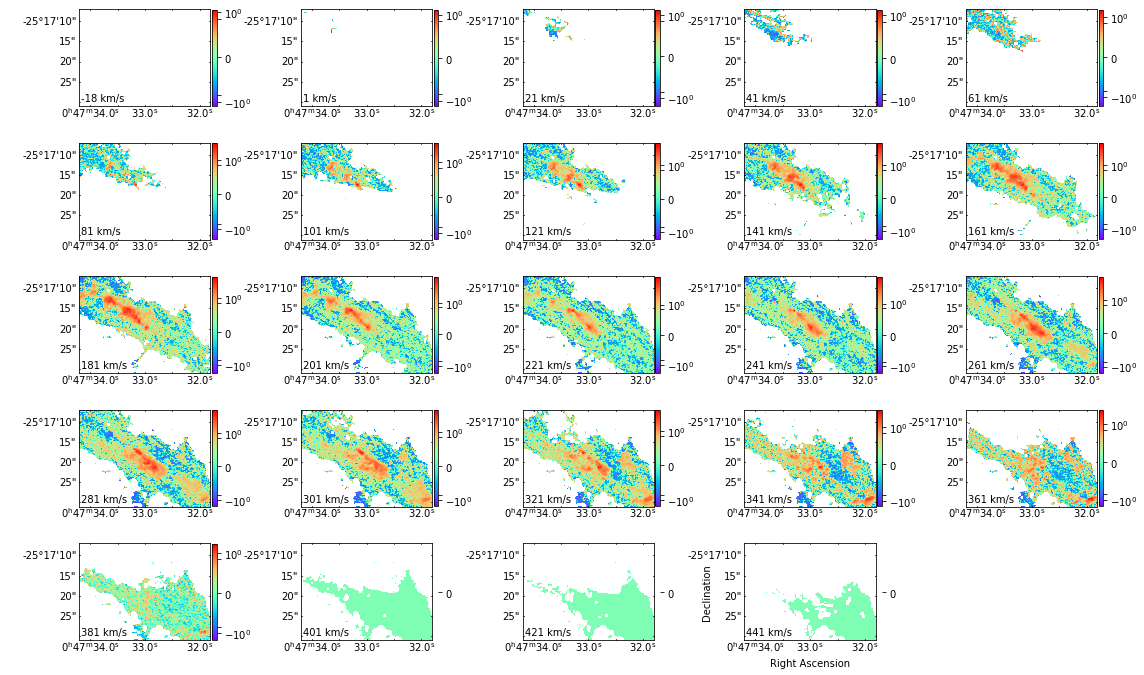

In [11]:


#####Zoom in

sc = SpectralCube.read('NGC253.HCN_4-3.pbcor.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = sc.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-50. *u.km / u.s, 450. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,15))

                                            
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(8,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    
    
    im = pylab.imshow(SC_Bin.hdu.data[i],cmap='rainbow',norm=colors.SymLogNorm(linthresh=.05))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01,ticks=[-1,-.5,0,.5,1]) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.HCN_4-3_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('NGC253.H13CN_4-3.pbcor.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,15))

                                            
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    
    
    im = pylab.imshow((SC_Bin.hdu.data[i]),cmap='rainbow',norm=colors.SymLogNorm(linthresh=.05))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01,ticks=[-1,-.5,0,.5,1]) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
        
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5.2,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.H13CN_4-3_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('HCN_J1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,15))

                                            
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    
    
    im = pylab.imshow((SC_Bin.hdu.data[i]),cmap='rainbow',norm=colors.SymLogNorm(linthresh=.05))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01,ticks=[-1,-.5,0,.5,1]) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.HCN_J1_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('HCOp_J1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(4,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,15))

                                            
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    
    
    im = pylab.imshow((SC_Bin.hdu.data[i]),cmap='rainbow',norm=colors.SymLogNorm(linthresh=.05))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01,ticks=[-1,-.5,0,.5,1]) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.HCO+_1-0_CM.jpeg")

In [ ]:




#H13CO+_J1-0, 86.754330 GHz, ref: https://iopscience.iop.org/article/10.1086/497881/pdf


#_and_SiO_J2-1 86.846998 GHz

# Use this to find freq range: regpix.meta['restfreq'] = [100 * u.GHz] # rest frequency 


#Here we specify the frequency and range of velocities (up to 320 m/s) and make a cube with only the H13CO+ data

path = 'H13COp_J1-0_SiO_J2-1.cube.fits'

cubeB = SpectralCube.read(path)


regpix = regions.RectanglePixelRegion(regions.PixCoord(int(cubeB.shape[1]/2), int(cubeB.shape[1]/2)), width=int(cubeB.shape[1]-1), height=int(cubeB.shape[1]-1))  
regpix.meta['range'] = [100 * u.km/u.s, 300 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 86.754330*u.GHz # rest frequency of H13CO+ J1-0
#print(type(regpix.meta['restfreq']))
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = cubeB.subcube_from_regions([regpix])  #Make the subcube with the specified frequency

sc = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=86.754330*u.GHz)
cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = sc.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position

scW = scN.wcs[:][:][0]

#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(3,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels
fig1 = pylab.figure(1,figsize=(15,15))
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    
    
    im = pylab.imshow(SC_Bin.hdu.data[i],cmap='rainbow',norm=colors.SymLogNorm(linthresh=.05))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01,ticks=[-1,-.5,0,.5,1]) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.H13CO+_J1-0_CM.jpeg")

In [ ]:
#H13CO+_J1-0, 86.754330 GHz, ref: https://iopscience.iop.org/article/10.1086/497881/pdf


#_and_SiO_J2-1 86.846998 GHz

# Use this to find freq range: regpix.meta['restfreq'] = [100 * u.GHz] # rest frequency 


#Here we specify the frequency and range of velocities (up to 320 m/s) and make a cube with only the H13CO+ data

path = 'H13COp_J1-0_SiO_J2-1.cube.fits'

cubeB = SpectralCube.read(path)


regpix = regions.RectanglePixelRegion(regions.PixCoord(int(cubeB.shape[1]/2), int(cubeB.shape[1]/2)), width=int(cubeB.shape[1]-1), height=int(cubeB.shape[1]-1))  
regpix.meta['range'] = [100 * u.km/u.s, 300 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 86.846998*u.GHz # rest frequency of SiOJ2-1
#print(type(regpix.meta['restfreq']))
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = cubeB.subcube_from_regions([regpix])  #Make the subcube with the specified frequency

sc = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=86.846998*u.GHz)
cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = sc.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position


scW = scN.wcs[:][:][0]

#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-300. *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(4,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels
fig1 = pylab.figure(1,figsize=(15,15))
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    
    
    im = pylab.imshow(SC_Bin.hdu.data[i],cmap='rainbow',norm=colors.SymLogNorm(linthresh=.05))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01,ticks=[-1,-.5,0,.5,1]) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.SiO_J2-1_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('H13CN_J1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels
fig1 = pylab.figure(1,figsize=(15,15))
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    
    
    im = pylab.imshow(SC_Bin.hdu.data[i],cmap='rainbow',norm=colors.SymLogNorm(linthresh=.05))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01,ticks=[-1,-.5,0,.5,1]) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5.3,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.H13CN_1-0_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('ngc253_co32_hires_common.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-200. *u.km / u.s, 700. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(3,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels
fig1 = pylab.figure(1,figsize=(15,15))
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    
    
    im = pylab.imshow(SC_Bin.hdu.data[i],cmap='rainbow',norm=colors.SymLogNorm(linthresh=.05))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01,ticks=[-1,-.5,0,.5,1]) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.CO_3-2_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('CCH_N1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels
fig1 = pylab.figure(1,figsize=(15,15))
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    
    
    im = pylab.imshow((SC_Bin.hdu.data[i]),cmap='rainbow',norm=colors.SymLogNorm(linthresh=.05))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01,ticks=[-1,-.5,0,.5,1]) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253_CCH_N1-0_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read("HC3N_11_10.fits") 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(4,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels
fig1 = pylab.figure(1,figsize=(15,15))
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    
    
    im = pylab.imshow((SC_Bin.hdu.data[i]),cmap='rainbow',norm=colors.SymLogNorm(linthresh=.05))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01,ticks=[-1,-.5,0,.5,1]) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="HC3N_11_10_CM.jpeg")

# Part 5: PV Plots

In [ ]:
sc = SpectralCube.read('NGC253.HCO+_4-3.pbcor.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(100 *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=2)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.HCO+_4-3.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.HCO+_4-3_PV.jpeg")

In [ ]:
sc = SpectralCube.read('NGC253.HCN_4-3.pbcor.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(100 *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=2)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.HCN_4-3.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.HCN_4-3_PV.jpeg")

In [ ]:
sc = SpectralCube.read('NGC253.H13CN_4-3.pbcor.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(100 *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=2)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.H13CN_4-3.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.H13CN_4-3_PV.jpeg")

In [ ]:
sc = SpectralCube.read('HCN_J1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)

SC_K_KMS_slab = SC_K_KMS.spectral_slab(100 *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=3)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.HCN_1-0.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.HCN_1-0_PV.jpeg")

In [ ]:
#H13CO+_J1-0, 86.754330 GHz, ref: https://iopscience.iop.org/article/10.1086/497881/pdf


#_and_SiO_J2-1 86.846998 GHz

# Use this to find freq range: regpix.meta['restfreq'] = [100 * u.GHz] # rest frequency 


#Here we specify the frequency and range of velocities (up to 320 m/s) and make a cube with only the H13CO+ data

path = 'H13COp_J1-0_SiO_J2-1.cube.fits'

cubeB = SpectralCube.read(path)


regpix = regions.RectanglePixelRegion(regions.PixCoord(int(cubeB.shape[1]/2), int(cubeB.shape[1]/2)), width=int(cubeB.shape[1]-1), height=int(cubeB.shape[1]-1))  
regpix.meta['range'] = [100 * u.km/u.s, 300 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 86.754330*u.GHz # rest frequency of H13CO+
#print(type(regpix.meta['restfreq']))
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = cubeB.subcube_from_regions([regpix])  #Make the subcube with the specified frequency
cube = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=86.754330*u.GHz)
cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = cube.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)   

scN = cube[:,raDP1[1]:raDP2[1],:] # Make a subcube based on position

#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(100 *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=4)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("H13COp_J1-0_SiO_J2-1.cube.fits (H13CO+)")
fig.savefig(bbox_inches='tight',fname="NGC253.H13CO+_1-0_PV.jpeg")

In [ ]:
#H13CO+_J1-0, 86.754330 GHz, ref: https://iopscience.iop.org/article/10.1086/497881/pdf


#_and_SiO_J2-1 86.846998 GHz

# Use this to find freq range: regpix.meta['restfreq'] = [100 * u.GHz] # rest frequency 


#Here we specify the frequency and range of velocities (up to 320 m/s) and make a cube with only the H13CO+ data

path = 'H13COp_J1-0_SiO_J2-1.cube.fits'

cubeB = SpectralCube.read(path)


regpix = regions.RectanglePixelRegion(regions.PixCoord(int(cubeB.shape[1]/2), int(cubeB.shape[1]/2)), width=int(cubeB.shape[1]-1), height=int(cubeB.shape[1]-1))  
regpix.meta['range'] = [100 * u.km/u.s, 300 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 86.846998*u.GHz # rest frequency of SiOJ2-1
#print(type(regpix.meta['restfreq']))
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = cubeB.subcube_from_regions([regpix])  #Make the subcube with the specified frequency
cube = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=86.846998*u.GHz)
cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = cube.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)   

scN = cube[:,raDP1[1]:raDP2[1],:] # Make a subcube based on position

#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities


fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=8)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("H13COp_J1-0_SiO_J2-1.cube.fits (SiO)")
fig.savefig(bbox_inches='tight',fname="NGC253.SiO_2-1_PV.jpeg")

In [ ]:
sc = SpectralCube.read('H13CN_J1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=2)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.H13CN_1-0.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.H13CN_1-0_PV.jpeg")

In [ ]:
sc = SpectralCube.read('ngc253_co32_hires_common.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=3)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.CO_3-2.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.CO_3-2_PV.jpeg")

In [ ]:
sc = SpectralCube.read('CCH_N1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=3)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253CCH_N1-0.cube.fits")
fig.savefig(bbox_inches='tight',fname="NGC253CCH_N1-0.cube.fits_PV.jpeg")

In [ ]:
sc = SpectralCube.read("HC3N_11_10.fits") 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=3)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.HC3N_11_10.fits.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253_HC3N_11_10.fits_PV.jpeg")

# Part 6: Reporojection

In [3]:
#Use NGC253 Repojection to do this

done


In [ ]:
'''
files = pylab.array(['NGC253.HCO+_4-3.pbcor.fits','NGC253.HCN_4-3.pbcor.fits','NGC253.H13CN_4-3.pbcor.fits','HCN_J1-0.cube.fits','HCOp_J1-0.cube.fits','H13CN_J1-0.cube.fits','ngc253_co32_hires_common.fits', 'CCH_N1-0.cube.fits','HC3N_J11-10_SO_J45-44.cube.fits'])
      
dub='H13COp_J1-0_SiO_J2-1.cube.fits'    


for i,file in enumerate(files):
    
    sc = SpectralCube.read(file)    
    if i==0:                                # Find location of brightest emission
        z,xp,yp = pylab.where(sc.hdu.data==np.nanmax(sc.hdu.data)) 
        yRaxDec = sc.wcs[:][:][0].pixel_to_world(yp,xp)
    y, x = sc.wcs[:][:][0].world_to_pixel(yRaxDec)# Gets the pixel for the same Ra/dec of each cube
    #Need to reduce cube size, but it won't work if theyre all the same size sometimes?
    if i ==0:
        subcube = sc[:,int(x)-50:int(x)+50,int(y)-50:int(y)+50] # Make a subcube
    if i ==1:
        subcube = sc[:,int(x)-51:int(x)+51,int(y)-51:int(y)+51] # Make a subcube
    if i ==2:
        subcube = sc[:,int(x)-52:int(x)+52,int(y)-52:int(y)+52] # Make a subcube
    if i ==3:
        subcube = sc[:,int(x)-52:int(x)+52,int(y)-52:int(y)+52] # Make a subcube
    if i ==4:
        subcube = sc[:,int(x)-52:int(x)+52,int(y)-52:int(y)+52] # Make a subcube
    if i ==5:
        subcube = sc[:,int(x)-52:int(x)+52,int(y)-52:int(y)+52] # Make a subcube        
    if i ==6:
        subcube = sc[:,int(x)-52:int(x)+52,int(y)-52:int(y)+52] # Make a subcube
    if i ==7:
        subcube = sc[:,int(x)-52:int(x)+52,int(y)-52:int(y)+52] # Make a subcube
    if i ==8:
        subcube = sc[:,int(x)-52:int(x)+52,int(y)-52:int(y)+52] # Make a subcube

        
    
    sc_kms = subcube.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    sc_slab = sc_kms.spectral_slab(-500. *u.km / u.s, 5000. *u.km / u.s)  # Crop out velocities we don't care about    
    sc_slab.allow_huge_operations=True    
    sc_K_kms = sc_slab.to(u.K)
    
    
    
    if i==0:
        vel, dec, ra = sc_K_kms.world[:,0,0]            # Grab the velocity axis to use for rebinning
        NGC_HCO_Plus = sc_K_kms.unmasked_copy()
        NGC_HCO_Plus.write('NGC_HCO_Plus.cube.K-kms.pbcor.fits',overwrite=True)        
    if i==1:
        NGC_HCN = sc_K_kms.unmasked_copy()
        NGC_HCN.write('NGC253_HCN.cube.reproject.K-kms.pbcor.fits',overwrite=True)
    if i==2:
        NGC_H13CN = sc_K_kms.unmasked_copy()#This one needs reprojection
    if i==3:
        veln, decn, ran = sc_K_kms.world[:,0,0]            # Need new vel axis because vrad!=2vrad
        NGC_HCN_J1 = sc_K_kms.unmasked_copy()
    if i==4:
        NGC_HCOP_J1 = sc_K_kms.unmasked_copy()
    if i==5:
        NGC_H13CN_J1 = sc_K_kms.unmasked_copy()
    if i==6:
        NGC_CO_J3_2 = sc_K_kms.unmasked_copy()
    if i==7:
        CCH_N1 = sc_K_kms.unmasked_copy()
    if i==8:
        HC3N_J11 = sc_K_kms.unmasked_copy()
#Make cubes out of the double fits

sc = SpectralCube.read(dub)
regpix = regions.RectanglePixelRegion(regions.PixCoord(int(sc.shape[1]/2), int(sc.shape[1]/2)), width=int(sc.shape[1]-1), height=int(sc.shape[1]-1))  
regpix.meta['range'] = [100 * u.km/u.s, 300 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 86.846998*u.GHz # rest frequency of SiJ2-1
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = sc.subcube_from_regions([regpix])  #Make the subcube with the specified frequency
cubeSi = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=86.846998*u.GHz)


scW = cubeSi.wcs[:][:][0]
y, x = cubeSi.wcs[:][:][0].world_to_pixel(yRaxDec)# Gets the pixel for the same Ra/dec of each cube
subcubeSi = cubeSi[:,int(x)-50:int(x)+50,int(y)-50:int(y)+50]



sc_kms = subcubeSi.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
sc_slab = sc_kms.spectral_slab(-50000. *u.km / u.s, 500000. *u.km / u.s)  # Crop out velocities we don't care about
sc_slab.allow_huge_operations=True
sc_K_kms = sc_slab.to(u.K)
SiJ2_1 = sc_K_kms.unmasked_copy()

#Make H13CoP cube
regpix = regions.RectanglePixelRegion(regions.PixCoord(int(sc.shape[1]/2), int(sc.shape[1]/2)), width=int(sc.shape[1]-1), height=int(sc.shape[1]-1))  
regpix.meta['range'] = [100 * u.km/u.s, 300 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 86.754330*u.GHz # rest frequency of H13CO+_J1-0, 86.754330 GHz
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = sc.subcube_from_regions([regpix])  #Make the subcube with the specified frequency
cubeH13CoP = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=86.754330*u.GHz)
scW = cubeH13CoP.wcs[:][:][0]


y, x = cubeH13CoP.wcs[:][:][0].world_to_pixel(yRaxDec)# Gets the pixel for the same Ra/dec of each cube
subcubeH13CoP = cubeH13CoP[:,int(x)-50:int(x)+50,int(y)-50:int(y)+50]

sc_kms = subcubeH13CoP.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
sc_slab = sc_kms.spectral_slab(-50000. *u.km / u.s, 500000. *u.km / u.s)  # Crop out velocities we don't care about
sc_slab.allow_huge_operations=True
sc_K_kms = sc_slab.to(u.K)
H13CoPJ1_0 = sc_K_kms.unmasked_copy()

print("done")'''

In [ ]:
#Must use new veln axis now
NGC_HCOP_J1.allow_huge_operations=True
HCNH = NGC_HCN_J1.header
NGC_HCOP_J1_reproject = NGC_HCOP_J1.reproject(HCNH,use_memmap=True)         
NGC_HCOP_J1_reproject_interp = NGC_HCOP_J1_reproject.spectral_interpolate(spectral_grid=veln) # Match velocities too         
NGC_HCOP_J1_reproject_interp.write('NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits',overwrite=True)      
        
print("YESA")

In [ ]:

SiJ2_1.allow_huge_operations=True
HCNH = NGC_HCN_J1.header
SiJ2_1_reproject = SiJ2_1.reproject(HCNH,use_memmap=True)         
SiJ2_1_reproject_interp = SiJ2_1_reproject.spectral_interpolate(spectral_grid=veln) # Match velocities too 

SiJ2_1_reproject_interp.write('SiJ2_1.cube.reproject.K-kms.pbcor.fits',overwrite=True)         
print("YESA")


In [ ]:


H13CoPJ1_0.allow_huge_operations=True
HCNH = NGC_HCN_J1.header
H13CoPJ1_0_reproject = H13CoPJ1_0.reproject(HCNH,use_memmap=True)         
H13CoPJ1_0_reproject_interp = H13CoPJ1_0_reproject.spectral_interpolate(spectral_grid=veln) # Match velocities too         
H13CoPJ1_0_reproject_interp.write('H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits',overwrite=True)      
        
print("YESA")


#H13CoPJ1_0.write('H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits',overwrite=True)

In [ ]:
NGC_H13CN_J1.allow_huge_operations=True
HCNH = NGC_HCN_J1.header
NGC_H13CN_J1_reproject = NGC_H13CN_J1.reproject(HCNH,use_memmap=True)         
NGC_H13CN_J1_reproject_interp = NGC_H13CN_J1_reproject.spectral_interpolate(spectral_grid=veln) # Match velocities too         
NGC_H13CN_J1_reproject_interp.write('NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits',overwrite=True)      
        
print("YESA")

In [ ]:
NGC_CO_J3_2.allow_huge_operations=True
HCNH = NGC_HCN_J1.header
NGC_CO_J3_2_reproject = NGC_CO_J3_2.reproject(HCNH,use_memmap=True)         
NGC_CO_J3_2_reproject_interp = NGC_CO_J3_2_reproject.spectral_interpolate(spectral_grid=veln) # Match velocities too         
NGC_CO_J3_2_reproject_interp.write('NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits',overwrite=True)      
        
print("YESA")

In [ ]:
CCH_N1.allow_huge_operations=True
HCNH = NGC_HCN_J1.header
CCH_N1_reproject = CCH_N1.reproject(HCNH,use_memmap=True)         
CCH_N1_reproject_interp = CCH_N1_reproject.spectral_interpolate(spectral_grid=veln) # Match velocities too         
CCH_N1_reproject_interp.write('CCH_N1.cube.reproject.K-kms.pbcor.fits',overwrite=True)      
        
print("YESA")

In [ ]:
HC3N_J11.allow_huge_operations=True
HCNH = NGC_HCN_J1.header
HC3N_J11_reproject = HC3N_J11.reproject(HCNH,use_memmap=True)         
HC3N_J11_reproject_interp = HC3N_J11_reproject.spectral_interpolate(spectral_grid=veln) # Match velocities too         
HC3N_J11_reproject_interp.write('HC3N_J11.cube.reproject.K-kms.pbcor.fits',overwrite=True)      
        
print("YESA")

In [ ]:
#All the cubes have been reprojected

# Part 7: Spectra

In [ ]:
#Plot the first 3 spectra
#NGC_HCO_Plus
#NGC_HCN
#NGC_H13CN
paths = pylab.array(['NGC_HCO_Plus.cube.K-kms.pbcor.fits',
                     'NGC253_HCN.cube.reproject.K-kms.pbcor.fits',
                     'NGC_H13CN.cube.reproject.K-kms.pbcor.fits'])

                                            # Image-dependent plotting variables
scale = pylab.array([1,1,1,1])             # This is a factor for multiplying fainter spectra
colors = pylab.array(['OrangeRed','GoldenRod','DarkOliveGreen','SteelBlue'])
mols = pylab.array(['HCO+','HCN','H13CN','$^{12}$C$^{17}$O']) #labels

                                            # Define the figure outside of loop b/c we don't need to do this 4x!
fig6 = pylab.figure(6,figsize=(15,5))
ax6=pylab.subplot() 
    
                                            # Loop through all 4 images
for i, path in enumerate(paths):
     
    
    sc = SpectralCube.read(path)
    vel, dec, ra = sc.world[:,0,0]          # For plotting purposes, I want to know the velocity for each channel
    if i==0:                                # Find location of brightest 13CO emission
        z,xp,yp = pylab.where(sc.hdu.data==np.nanmax(sc.hdu.data)) 
        yRaxDec = sc.wcs[:][:][0].pixel_to_world(yp,xp)
    y, x = sc.wcs[:][:][0].world_to_pixel(yRaxDec)# Gets the pixel for the same Ra/dec of each cube
    
                                            # Extract an average spectrum in a 20x20 pixel box
    
    subcube = sc.hdu.data[:,int(x)-1:int(x)+1,int(y)-1:int(y)+1] # Make a 20x20xN subcube
    spectrum = np.average(subcube,axis=(1,2))                        # Average in RA and Dec to get 1D spectrum


    if i==0:
        spectrum_13 = spectrum.copy()       # save this to calculate a ratio later
    if i==1:
        spectrum_12 = spectrum.copy()       # save this to calculate a ratio later
    if i==2:
        spectrum_18 = spectrum.copy()       # save this to calculate a ratio later
    if i==3:
        spectrum_17 = spectrum.copy()       # save this to calculate a ratio later
                
        
                                            # plot all spectra    
    ax6.plot(vel,spectrum*scale[i]+i*50,lw=1,drawstyle='steps-mid',color=colors[i])
    pylab.xlabel('Velocity (km/s)',fontsize=20)
    pylab.ylabel('Brightness Temperature (K)',fontsize=20)
    pylab.ylim(0,150)
    pylab.xlim(100,300)
    pylab.axhline(i*50,color='black',ls=':',lw=0.5)
    pylab.text(110,i*50+5,mols[i],color=colors[i],fontsize=20)
    if scale[i]!=1:
        pylab.text(-98,i*50+2,"x %i"%scale[i],color=colors[i],fontsize=20)
    ax6.tick_params(axis = 'both', which = 'major', labelsize = 15)


                                            # Plot a figure showing the line ratio
                                            # If we hadn't forced all the images to have the same velocity axis
                                            # using spectral_interpolate this would throw a big error!!
                
badchan13 = pylab.where(abs(spectrum_13) < 0.1)
badchan18 = pylab.where(abs(spectrum_18) < 0.1)


spectrum_13T=spectrum_13.copy()
spectrum_12T=spectrum_12.copy()
spectrum_18T=spectrum_18.copy()



spectrum_13T[badchan13] = np.nan
spectrum_18T[badchan18] = np.nan

badchan12 = pylab.where(spectrum_12 < 0.1)
spectrum_12T[badchan12] = np.nan

fig7 = pylab.figure(7,figsize=(15,5))
ax7=pylab.subplot() 
ax7.plot(vel,spectrum_12T/spectrum_13T,drawstyle='steps-mid',color="Green")
ax7.plot(vel,spectrum_13T/spectrum_18T,drawstyle='steps-mid',color="Red")
ax7.plot(vel,spectrum_12T/spectrum_18T,drawstyle='steps-mid',color="Blue")
pylab.xlim(100,300)
pylab.ylim(-1,8)
pylab.xlabel('Velocity (km/s)',fontsize=20)
pylab.ylabel('Ratio',fontsize=20)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)
pylab.text(109,4,"HCN/HCO+ Line Ratio",color="Green",fontsize=15)

pylab.text(109,5,"HCO+/H13CN Line Ratio",color="Red",fontsize=15)
pylab.text(109,6,"HCN/H13CN Line Ratio",color="Blue",fontsize=15)
fig6.savefig(bbox_inches='tight',fname="NGC_253_Spectra.png")
fig7.savefig(bbox_inches='tight',fname="NGC_253_Spectra_Ratio.png")


In [ ]:
#Plot the other 4 single spectra
#NGC_HCOP_J1
#NGC_HCN_J1
#H13CN_J1-0
#CO_3-2
#And the double spectra
#SiO
#H13CO+
# 'CCH_N1-0.cube.'
# HC3N
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_HCN_J_1_0.cube.reproject.K-kms.pbcor.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits'])

                                            # Image-dependent plotting variables
scale = pylab.array([.1,.2,1,.1,1.5,1.5,.5,.5])             # This is a factor for multiplying fainter spectra
colors = pylab.array(['OrangeRed','GoldenRod','DarkOliveGreen','SteelBlue','Black','Blue',"Purple","Cyan"])
mols = pylab.array(['HCO+J1_0','HCN_J1_0','H13CN_J1-0',"CO_3-2",'Si_J2_1','H13CO+_J1_0',"CCH_N1-0","HC3N_J11-10_SO_J45-44"]) #labels ,'Si_J2_1','H13CO+_J1_0', removed

fig6 = pylab.figure(6,figsize=(15,20))
ax6=pylab.subplot() 
    
                                            # Loop through all 4 images
for i, path in enumerate(paths):
    sc = SpectralCube.read(path)
    vel, dec, ra = sc.world[:,0,0]          # For plotting purposes, I want to know the velocity for each channel   
    if i==0:                                # Find location of brightest 13CO emission
        z,xp,yp = pylab.where(sc.hdu.data==np.nanmax(sc.hdu.data)) 
        yRaxDec2 = sc.wcs[:][:][0].pixel_to_world(yp,xp)
    y, x = sc.wcs[:][:][0].world_to_pixel(yRaxDec2)# Gets the pixel for the same Ra/dec of each cube
                                            # Extract an average spectrum in a 20x20 pixel box
    subcube = sc.hdu.data[:,int(x)-5:int(x)+5,int(y)-5:int(y)+5] # Make a 20x20xN subcube
    #print(subcube.shape)
    #print(subcube[0])
    spectrum = np.average(subcube,axis=(1,2))                        # Average in RA and Dec to get 1D spectrum
    #print(spectrum)

    if i==0:
        spectrum_13 = spectrum.copy()       # save this to calculate a ratio later
    if i==1:
        spectrum_12 = spectrum.copy()       # save this to calculate a ratio later
    if i==2:
        spectrum_18 = spectrum.copy()       # save this to calculate a ratio later
    if i==3:
        spectrum_17 = spectrum.copy()       # save this to calculate a ratio later
                
        
                                            # plot all spectra    
    ax6.plot(vel,spectrum*scale[i]+i*10,lw=1,drawstyle='steps-mid',color=colors[i])
    pylab.xlabel('Velocity (km/s)',fontsize=20)
    pylab.ylabel('Brightness Temperature (K)',fontsize=20)
    pylab.ylim(-1,10*8+4)
    pylab.xlim(100,300)
    pylab.axhline(i*10,color='black',ls=':',lw=0.5)
    pylab.text(105,i*10+3,mols[i],color=colors[i],fontsize=20)
    if scale[i]!=1:
        pylab.text(105,i*10+1,("x"+str(scale[i])),color=colors[i],fontsize=20)
    ax6.tick_params(axis = 'both', which = 'major', labelsize = 15)


                                            # Plot a figure showing the line ratio
                                            # If we hadn't forced all the images to have the same velocity axis
                                            # using spectral_interpolate this would throw a big error!!
                
badchan13 = pylab.where(abs(spectrum_13) < 0.01)
badchan18 = pylab.where(abs(spectrum_18) < 0.01)
badchan12 = pylab.where(abs(spectrum_12) < 0.01)
spectrum_12T=spectrum_12.copy()
spectrum_13T=spectrum_13.copy()
spectrum_18T=spectrum_18.copy()
spectrum_13T[badchan13] = np.nan
spectrum_18T[badchan18] = np.nan
spectrum_12T[badchan12] = np.nan

fig7 = pylab.figure(7,figsize=(15,5))
ax7=pylab.subplot() 
ax7.plot(vel,spectrum_12T/spectrum_18T,drawstyle='steps-mid',color="Green")
pylab.xlim(100,300)
pylab.ylim(-10,60)
pylab.xlabel('Velocity (km/s)',fontsize=20)
pylab.ylabel('Ratio',fontsize=20)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)
pylab.text(105,50,"HCN/H13CN",color="Green",fontsize=15)

fig6.savefig(bbox_inches='tight',fname="NGC_253__More_Spectra.png")
fig7.savefig(bbox_inches='tight',fname="NGC_253__More_Spectra_Ratio.png")


In [ ]:
#Spectra's Region, HCOP, HCN, H13CN J4-3


                                            # Define the figure outside of loop b/c we don't need to do this 4x!
fig1 = pylab.figure(figsize=(15,7.5))




new_path = 'NGC_HCO_Plus.cube.K-kms.pbcor.fits' 
subcubeN = SpectralCube.read(new_path)#Get iamge #[:,int(x)-50:int(x)+50,int(y)-50:int(y)+50] #Create zoomed cube

mom_0_Sub = subcubeN.moment(order=0,how='slice')

scWCS = mom_0_Sub.wcs

y, x = subcubeN.wcs[:][:][0].world_to_pixel(yRaxDec)# Gets the pixel for the same Ra/dec of each cube

ax2 = pylab.subplot(1,2,1,projection=subcubeN.wcs[0]) 

mom_0_Sub = np.nansum(subcubeN,axis=0) 
RA = ax2.coords[0]                                                                  # hi
Dec = ax2.coords[1]
im2 = pylab.imshow(mom_0_Sub,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)    
pylab.plot(y,x,'+',ms=10,mec='black',mfc='black',mew=3.5,alpha=.5)
pylab.annotate("Spectral Subcube location (2x2)",(y,x+5))
pylab.xlabel('Right Ascension',fontsize=10,labelpad=1)                               
pylab.ylabel('Declination',fontsize=10,labelpad=0)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density (K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10 )   
pylab.annotate(s='Integrated Flux Density (K km/s)',fontsize=10,xy=(0.02,0.91),xycoords="axes fraction")  
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
ax2.set_title("NGC253.HCO+_4-3.pbcor.fits")
pylab.tight_layout(w_pad=13,h_pad=1)


#Spectra's Region, other lines





new_path = 'NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits' 
subcubeN = SpectralCube.read(new_path)#Get iamge #[:,int(x)-50:int(x)+50,int(y)-50:int(y)+50] #Create zoomed cube

mom_0_Sub = subcubeN.moment(order=0,how='slice')

scWCS = mom_0_Sub.wcs

y, x = subcubeN.wcs[:][:][0].world_to_pixel(yRaxDec2)# Gets the pixel for the same Ra/dec of each cube

ax3 = pylab.subplot(1,2,2,projection=subcubeN.wcs[0]) 

mom_0_Sub = np.nansum(subcubeN,axis=0) 
RA = ax3.coords[0]                                                                  # hi
Dec = ax3.coords[1]
im3 = pylab.imshow(mom_0_Sub,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)   
pylab.plot(y,x,'+',ms=10,mec='black',mfc='black',mew=2.5,alpha=.5)
pylab.annotate("Spectral Subcube location (10x10)",(y,x+5))
pylab.xlabel('Right Ascension',fontsize=10,labelpad=1)                               
pylab.ylabel('Declination',fontsize=10,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density (K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Integrated Flux Density (K km/s)',fontsize=10,xy=(0.02,0.91),xycoords="axes fraction")  
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
pylab.tight_layout(w_pad=13,h_pad=1)

ax3.set_title('NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits' )


fig1.savefig(bbox_inches='tight',fname="NGC253_Lines_Pos_Integrated.jpeg")



# Part 8: Dendograms

0.30974987068034376 0.30974987068034376 nan NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits
() (18, 400, 488)
0.27818930867759334 0.27818930867759334 nan NGC_HCN_J1.cube.reproject.K-kms.pbcor.fits
() (16, 400, 488)
0.33942568511167004 0.33942568511167004 nan NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits
() (9, 400, 488)
0.817139116091404 0.817139116091404 nan NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits
() (64, 400, 488)
0.2837542636472352 0.2837542636472352 nan SiJ2_1.cube.reproject.K-kms.pbcor.fits
() (122, 400, 488)
0.27016514205320924 0.27016514205320924 nan H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits
() (123, 400, 488)
0.18841263505048683 0.18841263505048683 nan CCH_N1.cube.reproject.K-kms.pbcor.fits
() (1, 400, 488)
0.6645478506764585 0.6645478506764585 nan HC3N_J11.cube.reproject.K-kms.pbcor.fits
() (122, 400, 488)
0.5036470890045166 0.5036470890045166 nan NGC_H13CN.cube.reproject.K-kms.pbcor.fits
() (20, 400, 488)
0.1628960222005844 0.1628960222005844 nan NGC_HCO_Plus.cube.K-kms.p

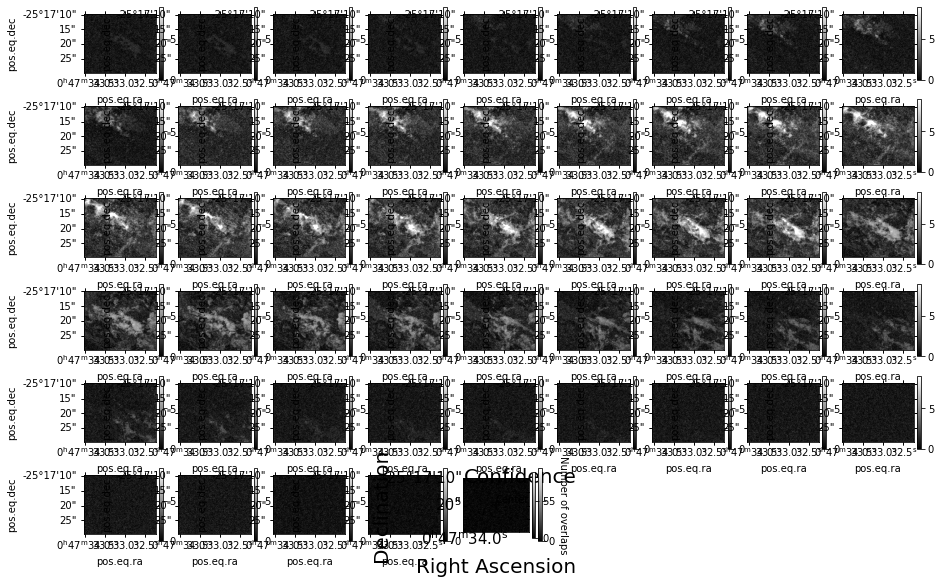

In [3]:
#Create a mask for all the cubes. 

###################No #If there is another cube that shares at least 67% of the structure, a structure is not to be masked.

#If there are multiple pixels that have greater than 3 sigma emission we will keep them (at most  (1-.95)**2 chance of incorrect label)

#Assign greater confidence to more overlaps


paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_HCN_J1.cube.reproject.K-kms.pbcor.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
FP = pylab.array(['HCOp_J1-0.cube.fits','HCN_J1-0.cube.fits','H13CN_J1-0.cube.fits','ngc253_co32_hires_common.fits',"SiO_2_1.fits",  "H13CO_Plus_1_0.fits",'CCH_N1-0.cube.fits',"HC3N_11_10.fits",'NGC253.H13CN_4-3.pbcor.fits','NGC253.HCO+_4-3.pbcor.fits','NGC253.HCN_4-3.pbcor.fits'])





SCWs=[]
cds=[]
Ns = [] #get sigmas for all cubes


#Find noises for first cubes
for i in range(len(FP)):
    sc = SpectralCube.read(paths[i])#FP[i])  
    
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
    sc_slab = sc_kms.spectral_slab(-500. *u.km / u.s, 1000. *u.km / u.s)  # Crop out velocities we don't care about    
    sc_slab.allow_huge_operations=True    
    
    sc_K_kms = sc_slab.to(u.K)
    
    scW = sc_K_kms.wcs[:][:][0]

    #Find Noise 
    Np1 = SkyCoord('00h47m33.0s', '-25d17m32s', frame='icrs')#These are away from the clusters
    Np2 = SkyCoord('00h47m31.0s', '-25d17m20s', frame='icrs')
    NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
    NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
    
        
    
    no = 0
    m=0
    while(True):

        Q = sc_K_kms[int(len(sc_K_kms)-no):len(sc_K_kms),:,:]#NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
        Nsc1 = Q.unmasked_copy()


        bp = np.where(Nsc1.hdu.data<0)

        Nsc1.hdu.data[bp]=np.nan
        #Find StandardDev of this noise cube
        #m=Nsc1.std(axis=0)/u.K
        m=Nsc1.std()/u.K
        
        no+=1
        if(float(np.nanmax(m))!=0.0 and str(float(np.nanmax(m))) != str(np.nan)):
            print(float(np.nanmax(m)),str(float(np.nanmax(m))), str(np.nan),paths[i])
            break
            
    print(np.shape(m),np.shape(Nsc1))
    
    Ns.append(m)
    
#Find noises for pre-masked cubes

'''
for i in range(len(FP)-3,len(FP)):
    sc = SpectralCube.read(FP[i])  
    
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
    sc_slab = sc_kms.spectral_slab(-500. *u.km / u.s, 1000. *u.km / u.s)  # Crop out velocities we don't care about    
    sc_slab.allow_huge_operations=True    
    
    sc_K_kms = sc_slab.to(u.K)
    
    scW = sc_K_kms.wcs[:][:][0]

    #Find Noise. Should be the minimum value since it must be at least 3 sigma to be unmasked
    
    Nsc1 = sc_K_kms.unmasked_copy()
    
    
    bp = np.where(Nsc1.hdu.data<=0)
    
    Nsc1.hdu.data[bp]=np.nan
    m=np.nanmin(Nsc1)/u.K
    print(m,np.shape(Nsc1))
    Ns.append(m)
'''  
    
#print(Ns)

for i in range(len(paths)):
    cube=SpectralCube.read(paths[i])
    #print(cube.max(axis=0)[0][0]/u.K,Ns[i][0][0])
    #spatial_mask = cube.max(axis=0)/u.K > 3*Ns[i]        
    
    #cubeM = cube.with_mask(spatial_mask)
    #print(np.shape(cube),np.shape(cubeM))
    cd = cube.hdu.data
    cds.append(cd)
    print(len(cds))
    SCWs.append(cube.wcs[:][:][0])

Confidences=cds[0]

pix = np.where(Confidences != 0)
Confidences[pix] = 0 
#print(Confidences.shape)
print(len(paths),len(FP),len(cds),len(Ns))
for i in range(len(cds)):
    print(cds[i].shape)
for i in range(len(cds)):
    
    GP = np.where(cds[i]>Ns[i]*1)#No abs for only emission
    print(np.shape(GP))
    print(len(Confidences))
    Confidences[GP]+=1

print(Confidences.shape)


   
print(Confidences.shape)

#Create a plot of all the confidence values

fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map
#print(SCWs[0])
#print(Confidences.shape)0
for n in np.arange(0,int(len(Confidences)/5)):   
    
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(9,9,n+1,projection=SCWs[0]) # We plot them in a grid    
    #im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(np.nanmean(Confidences[n*5:5*n+5],axis=0),cmap='gray',vmin=0,vmax=9)
    cb=pylab.colorbar(im,fraction=0.046,pad=0.04)  
    
'''
ax = pylab.subplot(1,1,1,projection=SCWs[0]) 
RA = ax.coords[0]                                                                  # 
Dec = ax.coords[1]
im = pylab.imshow(Confidences[int(len(Confidences)*.5)],cmap='rainbow')
'''
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(SCWs[0].world_to_pixel(center)[0]),int(SCWs[0].world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Number of overlaps',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Confidence',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


np.save('Confidence_data',Confidences)
np.save('Noises_K',Ns)

#Define common structures

#for i in range(len(paths)):


HCOp-J4-3_DendSigmas
NGC_HCO_Plus.cube.K-kms.pbcor.fits
[[0. 1. 1. ... 2. 1. 1.]
 [0. 2. 2. ... 2. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 2. 1.]
 [0. 0. 0. ... 1. 2. 1.]] (252, 400, 488) (252, 400, 488)
[nan nan nan ... nan nan nan]
(252, 400, 488) (252, 400, 488)
0.12999999999999598 arcsec 0.169999999999992 arcsec
8.839999999997895 pix2
(4048,)


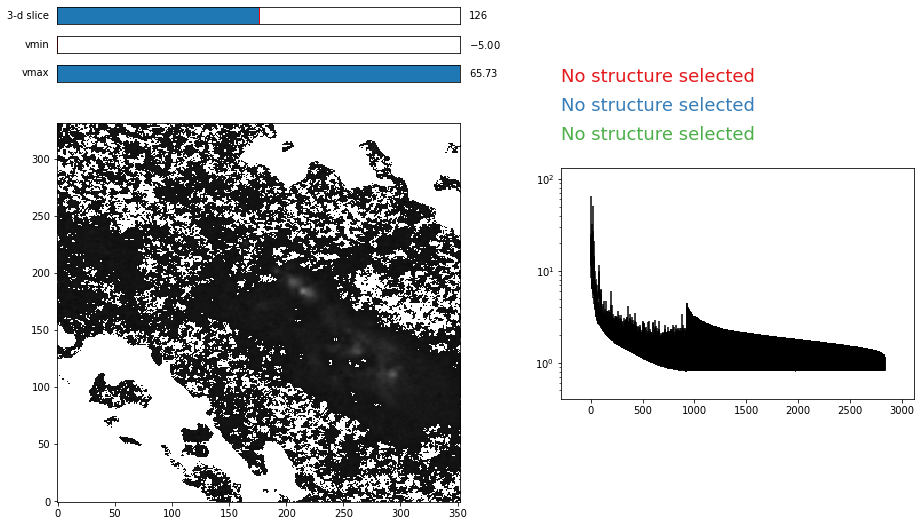

(1302,)
[5.24523161 0.70037466] [[ 9.71011781e-03 -5.50257991e-04]
 [-5.50257991e-04  3.16761742e-05]]
a =  5.2452316091023565 +- 0.09853993002347623
b =  0.700374660698518 +- 0.005628159041947014


<Figure size 2160x2160 with 0 Axes>

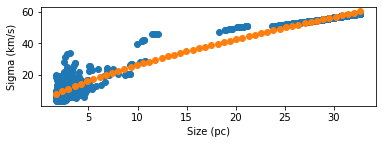

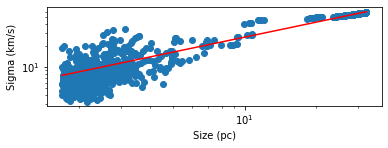

In [26]:
#HCO+ 4-3

Num=9
Overlaps=2
Ram_Limiter=1#What percent of the cube my ram can handle
Name = "HCOp-J4-3_Dend"
name = "HCOp_j_4_3_CM.jpeg"


NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
print(NameS)
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','HCN_J1-0.cube.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)
#Confidences = np.load('Confidence_data.npy')

#Noises = np.load('Noises_K.npy')
Noises = Ns
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]
print(Confidences[0],Confidences.shape,sc.hdu.data.shape)
BP = np.where(Confidences<Overlaps)#Overlaps)
sc.hdu.data[BP]=np.nan
print(sc.hdu.data[BP])
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

#cen_p1 = SkyCoord('00h47m33.6s', '-25d17m16.8s', frame='icrs')
#cen_p2 = SkyCoord('00h47m33.3s', '-25d17m14.2s', frame='icrs')

scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scn[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
raQDP1 = [int(scQW.world_to_pixel(cen_p1)[0]),int(scQW.world_to_pixel(cen_p1)[1])]
raQDP2 = [int(scQW.world_to_pixel(cen_p2)[0]),int(scQW.world_to_pixel(cen_p2)[1])]
scQF = scQn[:,raQDP1[1]:raQDP2[1],raQDP1[0]:raQDP2[0]] # Make a subcube
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

#Unload all the unimportant vars

del BP
del paths

d = astrodendro.Dendrogram.compute(datn,wcs=wcs,min_delta=m,min_value=m*5,min_npix=30) #The main culprit



header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['spatial_scale'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['spatial_scale']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
metadata["wcs"] = wcs
metadata["spectral_resolution"] = abs(header["CDELT3"])#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc
vel,NA,na = sc.world[:,0,0]

##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()
fig = plt.figure(1,figsize=(30,30))

scU = SpectralCube.read(path)  
scWU = scU.wcs[:][:][0]
raDP1U = [int(scWU.world_to_pixel(cen_p1)[0]),int(scWU.world_to_pixel(cen_p1)[1])]
raDP2U = [int(scWU.world_to_pixel(cen_p2)[0]),int(scWU.world_to_pixel(cen_p2)[1])]
scNU = scU[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),raDP1U[1]:raDP2U[1],raDP1U[0]:raDP2U[0]] # Make a subcube based on position
scWU = scNU.wcs[:][:][0]
#####
SC_KMSU = scNU.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMSU.allow_huge_operations=True
SC_K_KMSU = SC_KMSU.to(u.K)
SC_K_KMS_slabU = SC_K_KMSU.spectral_slab(-888. *u.km / u.s, 888. *u.km / u.s)  # Extract a subset of the velocities
ds=20
SC_CM = SC_K_KMS_slabU.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(5,5,n+1,projection=sc.wcs[:][:][0]) # We plot them in a grid    
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12) 
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        s = PPVStatistic(t)
        if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            k=0
            for ll in range(len(I[0])):
                if(I[0][ll] - int((n+.5)*ds) ==0):
                    k=int((n+.5)*ds)
                    break
            for ll in range(len(I[0])):
                if(k==int((n+.5)*ds)  and n!= 0):
                    break
                miN=3
                if(abs(I[0][ll] - int((n+.5)*ds)) <miN):
                    k=I[0][ll]
                    break
            if(k!=0):
                p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=.1,slice = k)
                ellipse = s.to_mpl_ellipse(edgecolor='pink', facecolor='pink',alpha=.1)
                ax.add_patch(ellipse)
            #print(t.indices())
            #break
if (noplot==False):
    fig.savefig(bbox_inches='tight',fname=name)


rads=np.array([])
sigmas=np.array([])
for t in d.all_structures: 
    
    I = t.indices()
    s = PPVStatistic(t)
        
    if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
        rads=np.append(rads,[(s.radius*metadata['spatial_scale']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc)]) #convert pixel to pc (then make it dimensionless)
        sigmas=np.append(sigmas,[(s.v_rms*metadata['spectral_resolution']/u.pix)])#Convert pixel to velocity (then make it dimensionless)


from scipy.optimize import curve_fit
print(np.shape(rads))
def func(R,a,b):
    return a*R**(b)
popt, pcov = curve_fit(func, rads*10**6, sigmas)
print(popt,pcov)
print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
fig = plt.figure()
ax = pylab.subplot(2, 1, 1)
xp1 = ax.scatter(rads*10**6,sigmas)
xs=np.linspace(np.nanmin(rads*10**6),np.nanmax(rads*10**6),50)
ys=func(xs,popt[0],popt[1])
xpa1 = ax.scatter(xs,ys)
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()
ax2 = pylab.subplot(2, 1, 2)
xp = ax2.scatter(rads*10**6,sigmas)
p = ax2.plot(xs,ys,c='red')
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()

np.save(NameS,sigmas)
np.save(NameR,rads)



HCN4-3Sigmas
NGC253_HCN.cube.reproject.K-kms.pbcor.fits
[[0. 1. 1. ... 2. 1. 1.]
 [0. 2. 2. ... 2. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 2. 1.]
 [0. 0. 0. ... 1. 2. 1.]] (252, 400, 488) (252, 400, 488)
[nan nan nan ... nan nan nan]
(252, 400, 488) (252, 400, 488)
0.12999999999999598 arcsec 0.169999999999992 arcsec
8.839999999997895 pix2
(18647,)


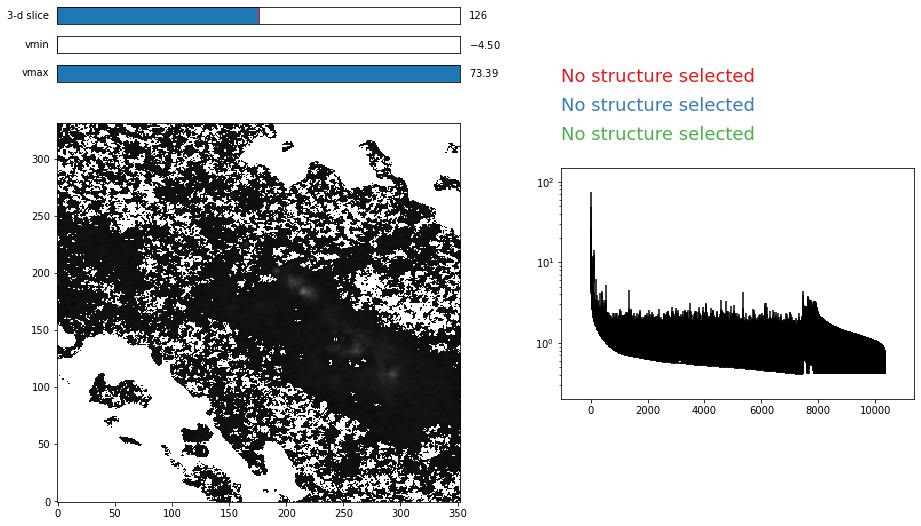

(8798,)
[7.45845015 0.55948345] [[ 5.87098862e-03 -2.12212666e-04]
 [-2.12212666e-04  7.90851199e-06]]
a =  7.45845014765227 +- 0.07662237677028376
b =  0.5594834469285881 +- 0.002812207672049102


<Figure size 2160x2160 with 0 Axes>

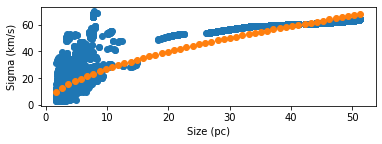

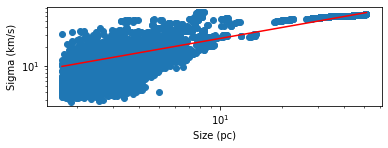

In [27]:
#HCN 4-3


Num = 10
Overlaps = 2
Ram_Limiter = 1
Name = "HCN4-3"
name = "HCN4_3_CM_Contours_DS_10.jpeg"
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
print(NameS)
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','HCN_J1-0.cube.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)
#Confidences = np.load('Confidence_data.npy')

#Noises = np.load('Noises_K.npy')
Noises = Ns
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]
print(Confidences[0],Confidences.shape,sc.hdu.data.shape)
BP = np.where(Confidences<Overlaps)#Overlaps)
sc.hdu.data[BP]=np.nan
print(sc.hdu.data[BP])
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

#cen_p1 = SkyCoord('00h47m33.6s', '-25d17m16.8s', frame='icrs')
#cen_p2 = SkyCoord('00h47m33.3s', '-25d17m14.2s', frame='icrs')

scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scn[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
raQDP1 = [int(scQW.world_to_pixel(cen_p1)[0]),int(scQW.world_to_pixel(cen_p1)[1])]
raQDP2 = [int(scQW.world_to_pixel(cen_p2)[0]),int(scQW.world_to_pixel(cen_p2)[1])]
scQF = scQn[:,raQDP1[1]:raQDP2[1],raQDP1[0]:raQDP2[0]] # Make a subcube
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

#Unload all the unimportant vars

del BP
del paths

d = astrodendro.Dendrogram.compute(datn,wcs=wcs,min_delta=m,min_value=m*5,min_npix=30) #The main culprit



header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['spatial_scale'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['spatial_scale']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
metadata["wcs"] = wcs
metadata["spectral_resolution"] = abs(header["CDELT3"])#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc
vel,NA,na = sc.world[:,0,0]

##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()
fig = plt.figure(1,figsize=(30,30))

scU = SpectralCube.read(path)  
scWU = scU.wcs[:][:][0]
raDP1U = [int(scWU.world_to_pixel(cen_p1)[0]),int(scWU.world_to_pixel(cen_p1)[1])]
raDP2U = [int(scWU.world_to_pixel(cen_p2)[0]),int(scWU.world_to_pixel(cen_p2)[1])]
scNU = scU[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),raDP1U[1]:raDP2U[1],raDP1U[0]:raDP2U[0]] # Make a subcube based on position
scWU = scNU.wcs[:][:][0]
#####
SC_KMSU = scNU.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMSU.allow_huge_operations=True
SC_K_KMSU = SC_KMSU.to(u.K)
SC_K_KMS_slabU = SC_K_KMSU.spectral_slab(-888. *u.km / u.s, 888. *u.km / u.s)  # Extract a subset of the velocities
ds=20
SC_CM = SC_K_KMS_slabU.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(5,5,n+1,projection=sc.wcs[:][:][0]) # We plot them in a grid    
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12) 
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        s = PPVStatistic(t)
        if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            k=0
            for ll in range(len(I[0])):
                if(I[0][ll] - int((n+.5)*ds) ==0):
                    k=int((n+.5)*ds)
                    break
            for ll in range(len(I[0])):
                if(k==int((n+.5)*ds)  and n!= 0):
                    break
                miN=3
                if(abs(I[0][ll] - int((n+.5)*ds)) <miN):
                    k=I[0][ll]
                    break
            if(k!=0):
                p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=.1,slice = k)
                ellipse = s.to_mpl_ellipse(edgecolor='pink', facecolor='pink',alpha=.1)
                ax.add_patch(ellipse)
            #print(t.indices())
            #break
if (noplot==False):
    fig.savefig(bbox_inches='tight',fname=name)


rads=np.array([])
sigmas=np.array([])
for t in d.all_structures: 
    
    I = t.indices()
    s = PPVStatistic(t)
        
    if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
        rads=np.append(rads,[(s.radius*metadata['spatial_scale']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc)]) #convert pixel to pc (then make it dimensionless)
        sigmas=np.append(sigmas,[(s.v_rms*metadata['spectral_resolution']/u.pix)])#Convert pixel to velocity (then make it dimensionless)


from scipy.optimize import curve_fit
print(np.shape(rads))
def func(R,a,b):
    return a*R**(b)
popt, pcov = curve_fit(func, rads*10**6, sigmas)
print(popt,pcov)
print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
fig = plt.figure()
ax = pylab.subplot(2, 1, 1)
xp1 = ax.scatter(rads*10**6,sigmas)
xs=np.linspace(np.nanmin(rads*10**6),np.nanmax(rads*10**6),50)
ys=func(xs,popt[0],popt[1])
xpa1 = ax.scatter(xs,ys)
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()
ax2 = pylab.subplot(2, 1, 2)
xp = ax2.scatter(rads*10**6,sigmas)
p = ax2.plot(xs,ys,c='red')
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()

np.save(NameS,sigmas)
np.save(NameR,rads)



H13CN4_3Sigmas
NGC_H13CN.cube.reproject.K-kms.pbcor.fits
[[0. 1. 1. ... 2. 1. 1.]
 [0. 2. 2. ... 2. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 2. 1.]
 [0. 0. 0. ... 1. 2. 1.]] (252, 400, 488) (252, 400, 488)
[nan nan nan ... nan nan nan]
(252, 400, 488) (252, 400, 488)
0.12999999999999598 arcsec 0.169999999999992 arcsec
8.839999999997895 pix2
(31,)


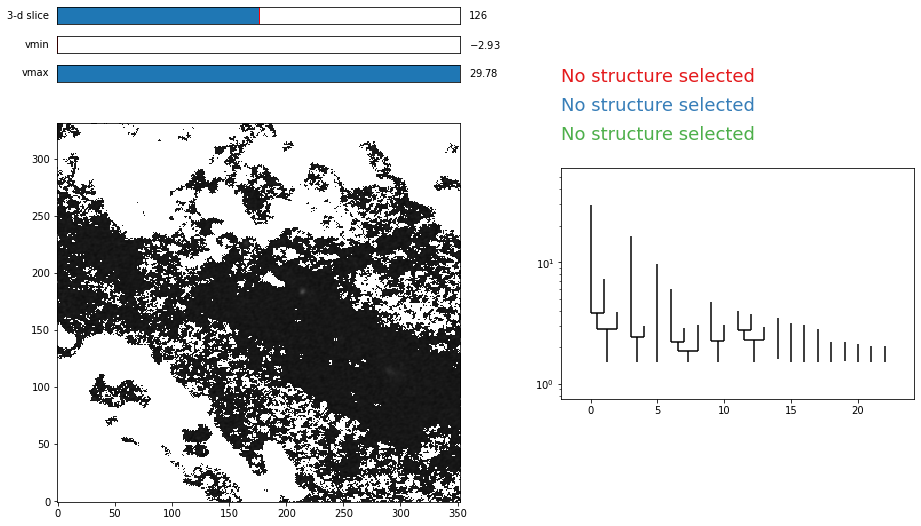

(6,)
[1.85647201 3.36039776] [[ 8.22460882 -6.75423363]
 [-6.75423363  5.60801966]]
a =  1.8564720098658554 +- 2.8678578805635113
b =  3.3603977596519634 +- 2.368125769467666


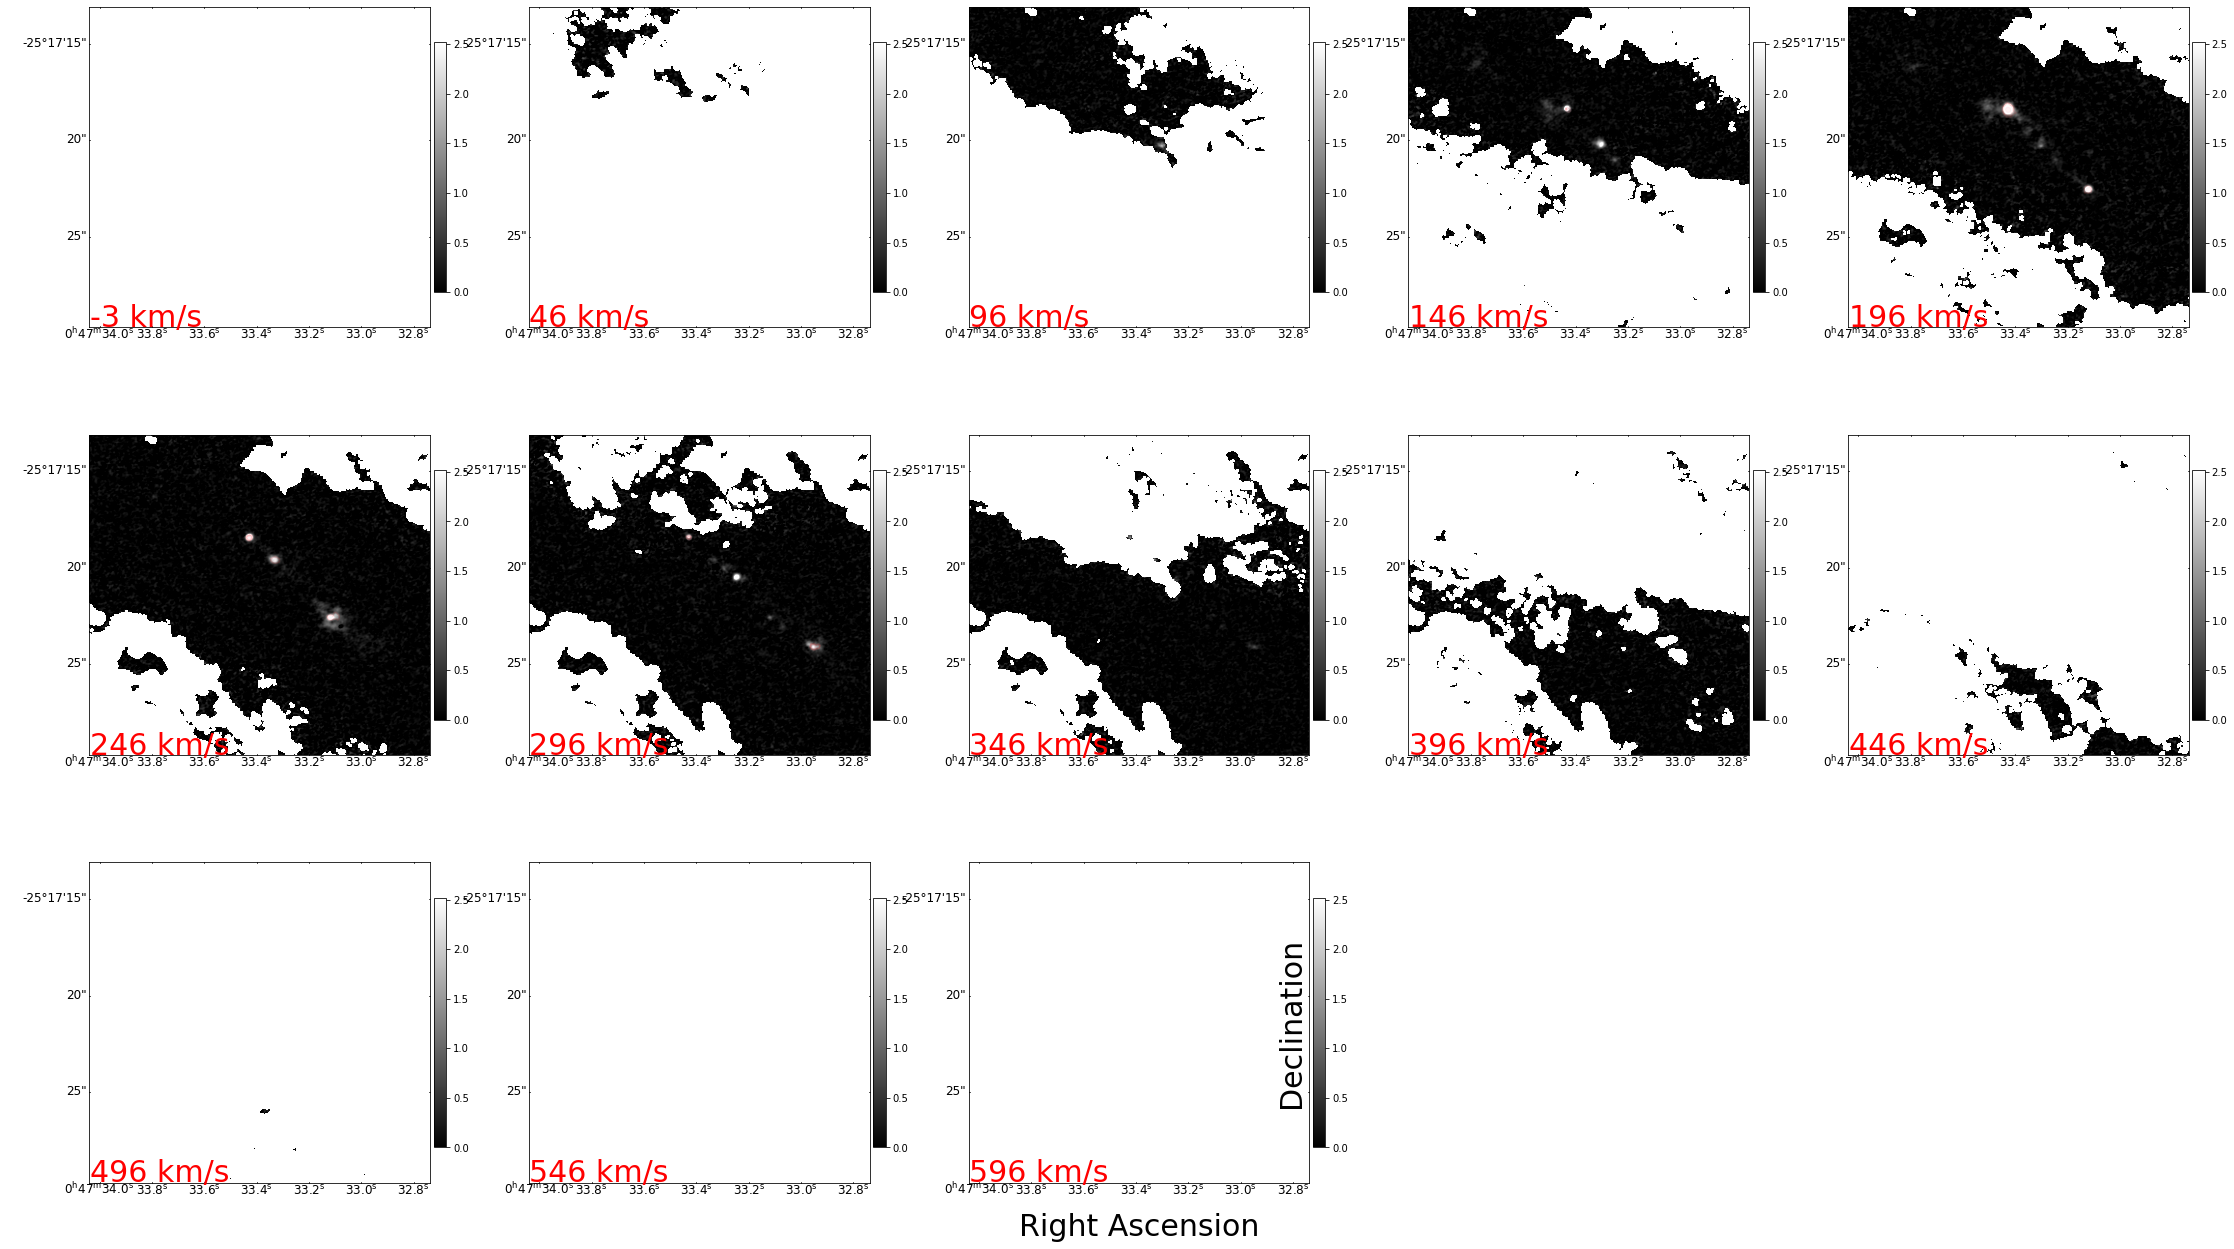

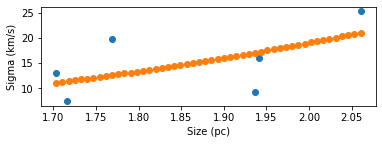

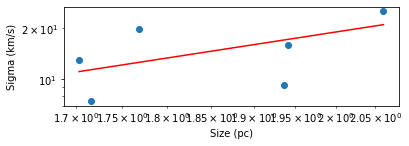

In [40]:
#H13CN 4-3


Num = 8
Overlaps = 2
Ram_Limiter = 1
Name = "H13CN4_3"
name = "H13CN4_3_CM_Contours_DS_10.jpeg"
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
print(NameS)
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','HCN_J1-0.cube.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)
#Confidences = np.load('Confidence_data.npy')

#Noises = np.load('Noises_K.npy')
Noises = Ns
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]
print(Confidences[0],Confidences.shape,sc.hdu.data.shape)
BP = np.where(Confidences<Overlaps)#Overlaps)
sc.hdu.data[BP]=np.nan
print(sc.hdu.data[BP])
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

#cen_p1 = SkyCoord('00h47m33.6s', '-25d17m16.8s', frame='icrs')
#cen_p2 = SkyCoord('00h47m33.3s', '-25d17m14.2s', frame='icrs')

scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scn[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
raQDP1 = [int(scQW.world_to_pixel(cen_p1)[0]),int(scQW.world_to_pixel(cen_p1)[1])]
raQDP2 = [int(scQW.world_to_pixel(cen_p2)[0]),int(scQW.world_to_pixel(cen_p2)[1])]
scQF = scQn[:,raQDP1[1]:raQDP2[1],raQDP1[0]:raQDP2[0]] # Make a subcube
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

#Unload all the unimportant vars

del BP
del paths

d = astrodendro.Dendrogram.compute(datn,wcs=wcs,min_delta=m,min_value=m*3,min_npix=10) #The main culprit



header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['spatial_scale'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['spatial_scale']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
metadata["wcs"] = wcs
metadata["spectral_resolution"] = abs(header["CDELT3"])#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc
vel,NA,na = sc.world[:,0,0]

##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()
fig = plt.figure(1,figsize=(30,30))

scU = SpectralCube.read(path)  
scWU = scU.wcs[:][:][0]
raDP1U = [int(scWU.world_to_pixel(cen_p1)[0]),int(scWU.world_to_pixel(cen_p1)[1])]
raDP2U = [int(scWU.world_to_pixel(cen_p2)[0]),int(scWU.world_to_pixel(cen_p2)[1])]
scNU = scU[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),raDP1U[1]:raDP2U[1],raDP1U[0]:raDP2U[0]] # Make a subcube based on position
scWU = scNU.wcs[:][:][0]
#####
SC_KMSU = scNU.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMSU.allow_huge_operations=True
SC_K_KMSU = SC_KMSU.to(u.K)
SC_K_KMS_slabU = SC_K_KMSU.spectral_slab(-888. *u.km / u.s, 888. *u.km / u.s)  # Extract a subset of the velocities
ds=20
SC_CM = SC_K_KMS_slabU.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=False #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(5,5,n+1,projection=sc.wcs[:][:][0]) # We plot them in a grid    
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*5)
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12) 
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        s = PPVStatistic(t)
        if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            k=0
            for ll in range(len(I[0])):
                if(I[0][ll] - int((n+.5)*ds) ==0):
                    k=int((n+.5)*ds)
                    break
            for ll in range(len(I[0])):
                if(k==int((n+.5)*ds)  and n!= 0):
                    break
                miN=3
                if(abs(I[0][ll] - int((n+.5)*ds)) <miN):
                    k=I[0][ll]
                    break
            if(k!=0):
                p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=.1,slice = k)
                ellipse = s.to_mpl_ellipse(edgecolor='pink', facecolor='pink',alpha=.1)
                ax.add_patch(ellipse)
            #print(t.indices())
            #break
if (noplot==False):
    fig.savefig(bbox_inches='tight',fname=name)


rads=np.array([])
sigmas=np.array([])
for t in d.all_structures: 
    
    I = t.indices()
    s = PPVStatistic(t)
        
    if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
        rads=np.append(rads,[(s.radius*metadata['spatial_scale']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc)]) #convert pixel to pc (then make it dimensionless)
        sigmas=np.append(sigmas,[(s.v_rms*metadata['spectral_resolution']/u.pix)])#Convert pixel to velocity (then make it dimensionless)


from scipy.optimize import curve_fit
print(np.shape(rads))
def func(R,a,b):
    return a*R**(b)
popt, pcov = curve_fit(func, rads*10**6, sigmas)
print(popt,pcov)
print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
fig = plt.figure()
ax = pylab.subplot(2, 1, 1)
xp1 = ax.scatter(rads*10**6,sigmas)
xs=np.linspace(np.nanmin(rads*10**6),np.nanmax(rads*10**6),50)
ys=func(xs,popt[0],popt[1])
xpa1 = ax.scatter(xs,ys)
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()
ax2 = pylab.subplot(2, 1, 2)
xp = ax2.scatter(rads*10**6,sigmas)
p = ax2.plot(xs,ys,c='red')
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()

np.save(NameS,sigmas)
np.save(NameR,rads)



HCOp-J1_DendSigmas
NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits
[[0. 1. 1. ... 2. 1. 1.]
 [0. 2. 2. ... 2. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 2. 1.]
 [0. 0. 0. ... 1. 2. 1.]] (252, 400, 488) (252, 400, 488)
[nan nan nan ... nan nan nan]
(252, 400, 488) (252, 400, 488)
0.1839043346733 arcsec 0.250526942496108 arcsec
18.429196270990186 pix2
(1603,)


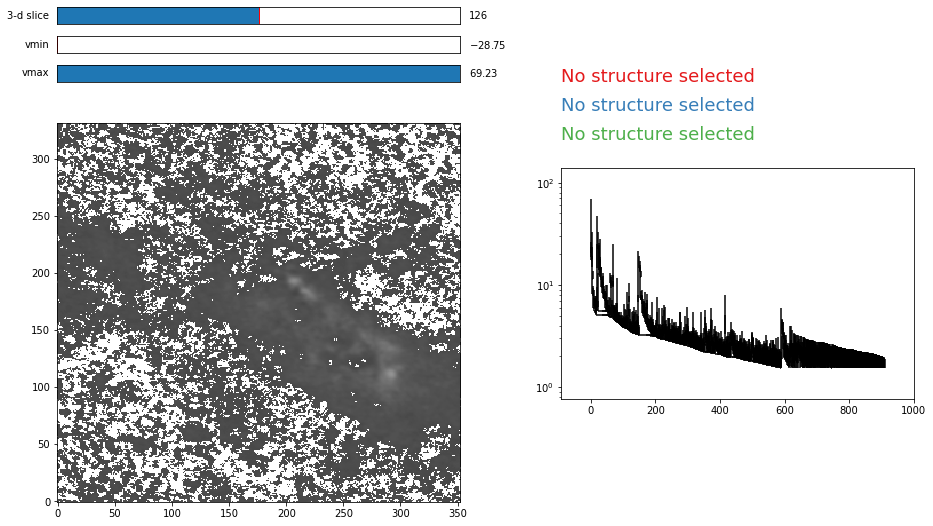

(727,)
[4.42546051 0.737673  ] [[ 7.71875915e-03 -4.98425227e-04]
 [-4.98425227e-04  3.26104443e-05]]
a =  4.425460510736074 +- 0.08785646903012619
b =  0.7376729967856506 +- 0.00571055551605478


<Figure size 2160x2160 with 0 Axes>

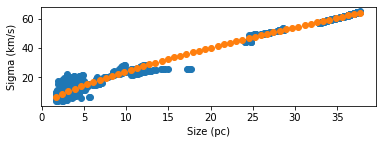

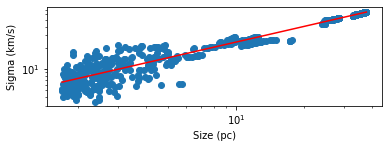

In [31]:
#HCO+_J1-0

Num=0
Overlaps=2
Ram_Limiter=1#What percent of the cube my ram can handle
Name = "HCOp-J1_Dend"
name ="HCOp_J1_0_Countours_CM_DS_10.jpeg"
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
print(NameS)
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','HCN_J1-0.cube.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)
#Confidences = np.load('Confidence_data.npy')

#Noises = np.load('Noises_K.npy')
Noises = Ns
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]
print(Confidences[0],Confidences.shape,sc.hdu.data.shape)
BP = np.where(Confidences<Overlaps)#Overlaps)
sc.hdu.data[BP]=np.nan
print(sc.hdu.data[BP])
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

#cen_p1 = SkyCoord('00h47m33.6s', '-25d17m16.8s', frame='icrs')
#cen_p2 = SkyCoord('00h47m33.3s', '-25d17m14.2s', frame='icrs')

scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scn[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
raQDP1 = [int(scQW.world_to_pixel(cen_p1)[0]),int(scQW.world_to_pixel(cen_p1)[1])]
raQDP2 = [int(scQW.world_to_pixel(cen_p2)[0]),int(scQW.world_to_pixel(cen_p2)[1])]
scQF = scQn[:,raQDP1[1]:raQDP2[1],raQDP1[0]:raQDP2[0]] # Make a subcube
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

#Unload all the unimportant vars

del BP
del paths

d = astrodendro.Dendrogram.compute(datn,wcs=wcs,min_delta=m,min_value=m*5,min_npix=30) #The main culprit



header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['spatial_scale'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['spatial_scale']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
metadata["wcs"] = wcs
metadata["spectral_resolution"] = abs(header["CDELT3"])#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc
vel,NA,na = sc.world[:,0,0]

##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()
fig = plt.figure(1,figsize=(30,30))

scU = SpectralCube.read(path)  
scWU = scU.wcs[:][:][0]
raDP1U = [int(scWU.world_to_pixel(cen_p1)[0]),int(scWU.world_to_pixel(cen_p1)[1])]
raDP2U = [int(scWU.world_to_pixel(cen_p2)[0]),int(scWU.world_to_pixel(cen_p2)[1])]
scNU = scU[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),raDP1U[1]:raDP2U[1],raDP1U[0]:raDP2U[0]] # Make a subcube based on position
scWU = scNU.wcs[:][:][0]
#####
SC_KMSU = scNU.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMSU.allow_huge_operations=True
SC_K_KMSU = SC_KMSU.to(u.K)
SC_K_KMS_slabU = SC_K_KMSU.spectral_slab(-888. *u.km / u.s, 888. *u.km / u.s)  # Extract a subset of the velocities
ds=20
SC_CM = SC_K_KMS_slabU.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(5,5,n+1,projection=sc.wcs[:][:][0]) # We plot them in a grid    
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12) 
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        s = PPVStatistic(t)
        if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            k=0
            for ll in range(len(I[0])):
                if(I[0][ll] - int((n+.5)*ds) ==0):
                    k=int((n+.5)*ds)
                    break
            for ll in range(len(I[0])):
                if(k==int((n+.5)*ds)  and n!= 0):
                    break
                miN=3
                if(abs(I[0][ll] - int((n+.5)*ds)) <miN):
                    k=I[0][ll]
                    break
            if(k!=0):
                p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=.1,slice = k)
                ellipse = s.to_mpl_ellipse(edgecolor='pink', facecolor='pink',alpha=.1)
                ax.add_patch(ellipse)
            #print(t.indices())
            #break
if (noplot==False):
    fig.savefig(bbox_inches='tight',fname=name)


rads=np.array([])
sigmas=np.array([])
for t in d.all_structures: 
    
    I = t.indices()
    s = PPVStatistic(t)
        
    if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
        rads=np.append(rads,[(s.radius*metadata['spatial_scale']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc)]) #convert pixel to pc (then make it dimensionless)
        sigmas=np.append(sigmas,[(s.v_rms*metadata['spectral_resolution']/u.pix)])#Convert pixel to velocity (then make it dimensionless)


from scipy.optimize import curve_fit
print(np.shape(rads))
def func(R,a,b):
    return a*R**(b)
popt, pcov = curve_fit(func, rads*10**6, sigmas)
print(popt,pcov)
print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
fig = plt.figure()
ax = pylab.subplot(2, 1, 1)
xp1 = ax.scatter(rads*10**6,sigmas)
xs=np.linspace(np.nanmin(rads*10**6),np.nanmax(rads*10**6),50)
ys=func(xs,popt[0],popt[1])
xpa1 = ax.scatter(xs,ys)
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()
ax2 = pylab.subplot(2, 1, 2)
xp = ax2.scatter(rads*10**6,sigmas)
p = ax2.plot(xs,ys,c='red')
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()

np.save(NameS,sigmas)
np.save(NameR,rads)



H13CN-J1_DendSigmas
NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits
[[0. 1. 1. ... 2. 1. 1.]
 [0. 2. 2. ... 2. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 2. 1.]
 [0. 0. 0. ... 1. 2. 1.]] (252, 400, 488) (252, 400, 488)
[nan nan nan ... nan nan nan]
(252, 400, 488) (252, 400, 488)
0.193741553900124 arcsec 0.2583761863464 arcsec
20.02328153341261 pix2
(142,)


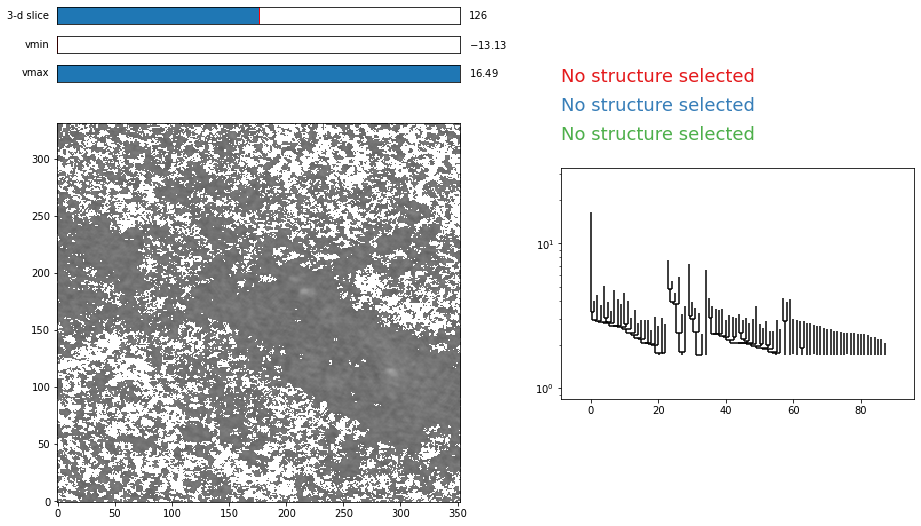

(60,)
[7.24079157 0.58907673] [[ 0.41412044 -0.03317386]
 [-0.03317386  0.00285919]]
a =  7.240791573153101 +- 0.6435219065519807
b =  0.5890767318036976 +- 0.05347141882516133


<Figure size 2160x2160 with 0 Axes>

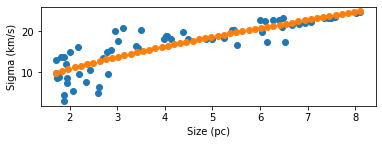

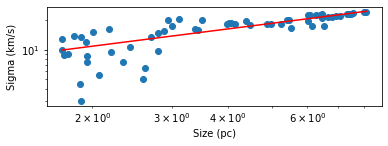

In [32]:
##### H13CN_J1-0

Num=2
Overlaps=2
Ram_Limiter=1#What percent of the cube my ram can handle
Name = "H13CN-J1_Dend"
name ="H13CN_J1_0_Countours_CM.jpeg"
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
print(NameS)
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','HCN_J1-0.cube.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)
#Confidences = np.load('Confidence_data.npy')

#Noises = np.load('Noises_K.npy')
Noises = Ns
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]
print(Confidences[0],Confidences.shape,sc.hdu.data.shape)
BP = np.where(Confidences<Overlaps)#Overlaps)
sc.hdu.data[BP]=np.nan
print(sc.hdu.data[BP])
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

#cen_p1 = SkyCoord('00h47m33.6s', '-25d17m16.8s', frame='icrs')
#cen_p2 = SkyCoord('00h47m33.3s', '-25d17m14.2s', frame='icrs')

scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scn[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
raQDP1 = [int(scQW.world_to_pixel(cen_p1)[0]),int(scQW.world_to_pixel(cen_p1)[1])]
raQDP2 = [int(scQW.world_to_pixel(cen_p2)[0]),int(scQW.world_to_pixel(cen_p2)[1])]
scQF = scQn[:,raQDP1[1]:raQDP2[1],raQDP1[0]:raQDP2[0]] # Make a subcube
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

#Unload all the unimportant vars

del BP
del paths

d = astrodendro.Dendrogram.compute(datn,wcs=wcs,min_delta=m,min_value=m*5,min_npix=30) #The main culprit



header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['spatial_scale'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['spatial_scale']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
metadata["wcs"] = wcs
metadata["spectral_resolution"] = abs(header["CDELT3"])#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc
vel,NA,na = sc.world[:,0,0]

##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()
fig = plt.figure(1,figsize=(30,30))

scU = SpectralCube.read(path)  
scWU = scU.wcs[:][:][0]
raDP1U = [int(scWU.world_to_pixel(cen_p1)[0]),int(scWU.world_to_pixel(cen_p1)[1])]
raDP2U = [int(scWU.world_to_pixel(cen_p2)[0]),int(scWU.world_to_pixel(cen_p2)[1])]
scNU = scU[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),raDP1U[1]:raDP2U[1],raDP1U[0]:raDP2U[0]] # Make a subcube based on position
scWU = scNU.wcs[:][:][0]
#####
SC_KMSU = scNU.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMSU.allow_huge_operations=True
SC_K_KMSU = SC_KMSU.to(u.K)
SC_K_KMS_slabU = SC_K_KMSU.spectral_slab(-888. *u.km / u.s, 888. *u.km / u.s)  # Extract a subset of the velocities
ds=20
SC_CM = SC_K_KMS_slabU.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(5,5,n+1,projection=sc.wcs[:][:][0]) # We plot them in a grid    
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12) 
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        s = PPVStatistic(t)
        if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            k=0
            for ll in range(len(I[0])):
                if(I[0][ll] - int((n+.5)*ds) ==0):
                    k=int((n+.5)*ds)
                    break
            for ll in range(len(I[0])):
                if(k==int((n+.5)*ds)  and n!= 0):
                    break
                miN=3
                if(abs(I[0][ll] - int((n+.5)*ds)) <miN):
                    k=I[0][ll]
                    break
            if(k!=0):
                p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=.1,slice = k)
                ellipse = s.to_mpl_ellipse(edgecolor='pink', facecolor='pink',alpha=.1)
                ax.add_patch(ellipse)
            #print(t.indices())
            #break
if (noplot==False):
    fig.savefig(bbox_inches='tight',fname=name)


rads=np.array([])
sigmas=np.array([])
for t in d.all_structures: 
    
    I = t.indices()
    s = PPVStatistic(t)
        
    if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
        rads=np.append(rads,[(s.radius*metadata['spatial_scale']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc)]) #convert pixel to pc (then make it dimensionless)
        sigmas=np.append(sigmas,[(s.v_rms*metadata['spectral_resolution']/u.pix)])#Convert pixel to velocity (then make it dimensionless)


from scipy.optimize import curve_fit
print(np.shape(rads))
def func(R,a,b):
    return a*R**(b)
popt, pcov = curve_fit(func, rads*10**6, sigmas)
print(popt,pcov)
print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
fig = plt.figure()
ax = pylab.subplot(2, 1, 1)
xp1 = ax.scatter(rads*10**6,sigmas)
xs=np.linspace(np.nanmin(rads*10**6),np.nanmax(rads*10**6),50)
ys=func(xs,popt[0],popt[1])
xpa1 = ax.scatter(xs,ys)
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()
ax2 = pylab.subplot(2, 1, 2)
xp = ax2.scatter(rads*10**6,sigmas)
p = ax2.plot(xs,ys,c='red')
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()

np.save(NameS,sigmas)
np.save(NameR,rads)



SiO_J2-1Sigmas
SiJ2_1.cube.reproject.K-kms.pbcor.fits
[[0. 1. 1. ... 2. 1. 1.]
 [0. 2. 2. ... 2. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 2. 1.]
 [0. 0. 0. ... 1. 2. 1.]] (252, 400, 488) (252, 400, 488)
[nan nan nan ... nan nan nan]
(252, 400, 488) (252, 400, 488)
0.20722991228103602 arcsec 0.28256428241730003 arcsec
23.422308583632642 pix2
(105,)


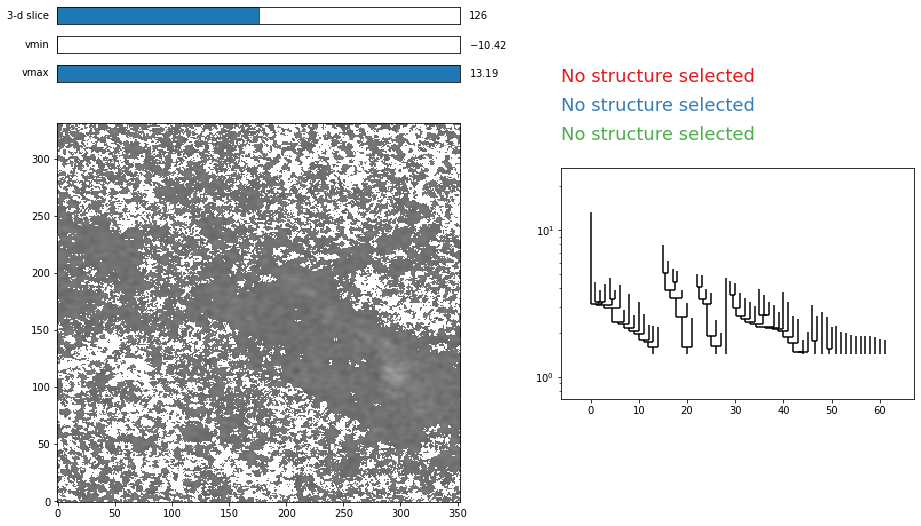

(44,)
[6.10280233 0.64080791] [[ 0.57593147 -0.05264762]
 [-0.05264762  0.00507358]]
a =  6.102802330445413 +- 0.7589014913864535
b =  0.6408079065484257 +- 0.07122905353009255


<Figure size 2160x2160 with 0 Axes>

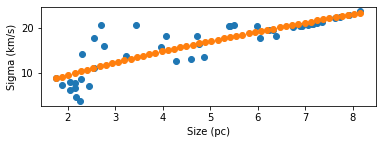

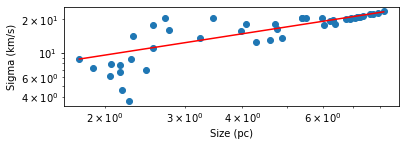

In [33]:
#SiO_J2-1


Num=4
Overlaps=2
Ram_Limiter=1#What percent of the cube my ram can handle
Name = "SiO_J2-1"
name = "SiO_J2_1_CM_Contours_DS_10.jpeg"
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
print(NameS)
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','HCN_J1-0.cube.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)
#Confidences = np.load('Confidence_data.npy')

#Noises = np.load('Noises_K.npy')
Noises = Ns
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]
print(Confidences[0],Confidences.shape,sc.hdu.data.shape)
BP = np.where(Confidences<Overlaps)#Overlaps)
sc.hdu.data[BP]=np.nan
print(sc.hdu.data[BP])
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

#cen_p1 = SkyCoord('00h47m33.6s', '-25d17m16.8s', frame='icrs')
#cen_p2 = SkyCoord('00h47m33.3s', '-25d17m14.2s', frame='icrs')

scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scn[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
raQDP1 = [int(scQW.world_to_pixel(cen_p1)[0]),int(scQW.world_to_pixel(cen_p1)[1])]
raQDP2 = [int(scQW.world_to_pixel(cen_p2)[0]),int(scQW.world_to_pixel(cen_p2)[1])]
scQF = scQn[:,raQDP1[1]:raQDP2[1],raQDP1[0]:raQDP2[0]] # Make a subcube
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

#Unload all the unimportant vars

del BP
del paths

d = astrodendro.Dendrogram.compute(datn,wcs=wcs,min_delta=m,min_value=m*5,min_npix=30) #The main culprit



header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['spatial_scale'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['spatial_scale']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
metadata["wcs"] = wcs
metadata["spectral_resolution"] = abs(header["CDELT3"])#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc
vel,NA,na = sc.world[:,0,0]

##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()
fig = plt.figure(1,figsize=(30,30))

scU = SpectralCube.read(path)  
scWU = scU.wcs[:][:][0]
raDP1U = [int(scWU.world_to_pixel(cen_p1)[0]),int(scWU.world_to_pixel(cen_p1)[1])]
raDP2U = [int(scWU.world_to_pixel(cen_p2)[0]),int(scWU.world_to_pixel(cen_p2)[1])]
scNU = scU[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),raDP1U[1]:raDP2U[1],raDP1U[0]:raDP2U[0]] # Make a subcube based on position
scWU = scNU.wcs[:][:][0]
#####
SC_KMSU = scNU.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMSU.allow_huge_operations=True
SC_K_KMSU = SC_KMSU.to(u.K)
SC_K_KMS_slabU = SC_K_KMSU.spectral_slab(-888. *u.km / u.s, 888. *u.km / u.s)  # Extract a subset of the velocities
ds=20
SC_CM = SC_K_KMS_slabU.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(5,5,n+1,projection=sc.wcs[:][:][0]) # We plot them in a grid    
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12) 
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        s = PPVStatistic(t)
        if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            k=0
            for ll in range(len(I[0])):
                if(I[0][ll] - int((n+.5)*ds) ==0):
                    k=int((n+.5)*ds)
                    break
            for ll in range(len(I[0])):
                if(k==int((n+.5)*ds)  and n!= 0):
                    break
                miN=3
                if(abs(I[0][ll] - int((n+.5)*ds)) <miN):
                    k=I[0][ll]
                    break
            if(k!=0):
                p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=.1,slice = k)
                ellipse = s.to_mpl_ellipse(edgecolor='pink', facecolor='pink',alpha=.1)
                ax.add_patch(ellipse)
            #print(t.indices())
            #break
if (noplot==False):
    fig.savefig(bbox_inches='tight',fname=name)


rads=np.array([])
sigmas=np.array([])
for t in d.all_structures: 
    
    I = t.indices()
    s = PPVStatistic(t)
        
    if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
        rads=np.append(rads,[(s.radius*metadata['spatial_scale']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc)]) #convert pixel to pc (then make it dimensionless)
        sigmas=np.append(sigmas,[(s.v_rms*metadata['spectral_resolution']/u.pix)])#Convert pixel to velocity (then make it dimensionless)


from scipy.optimize import curve_fit
print(np.shape(rads))
def func(R,a,b):
    return a*R**(b)
popt, pcov = curve_fit(func, rads*10**6, sigmas)
print(popt,pcov)
print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
fig = plt.figure()
ax = pylab.subplot(2, 1, 1)
xp1 = ax.scatter(rads*10**6,sigmas)
xs=np.linspace(np.nanmin(rads*10**6),np.nanmax(rads*10**6),50)
ys=func(xs,popt[0],popt[1])
xpa1 = ax.scatter(xs,ys)
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()
ax2 = pylab.subplot(2, 1, 2)
xp = ax2.scatter(rads*10**6,sigmas)
p = ax2.plot(xs,ys,c='red')
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()

np.save(NameS,sigmas)
np.save(NameR,rads)



CO 3-2Sigmas
NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits
[[0. 1. 1. ... 2. 1. 1.]
 [0. 2. 2. ... 2. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 2. 1.]
 [0. 0. 0. ... 1. 2. 1.]] (252, 400, 488) (252, 400, 488)
[nan nan nan ... nan nan nan]
(252, 400, 488) (252, 400, 488)
0.174999999999996 arcsec 0.174999999999996 arcsec
12.24999999999748 pix2
(1701,)


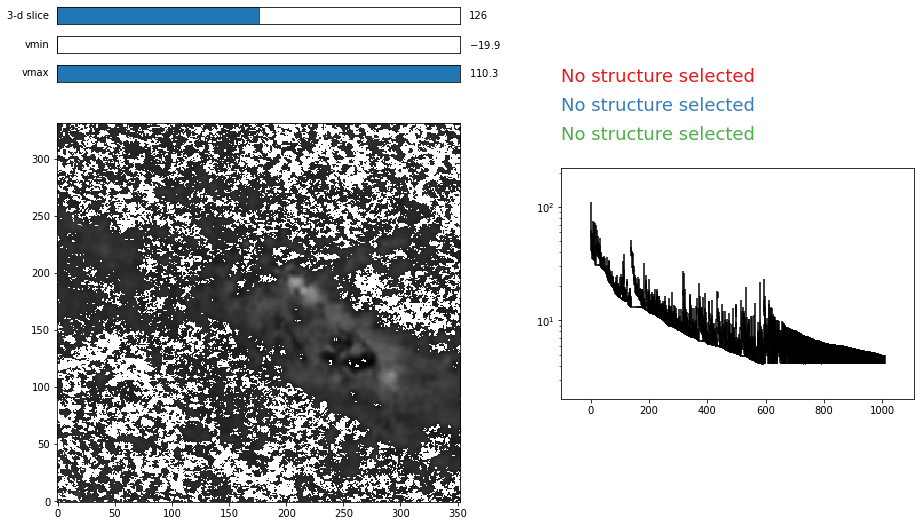

(785,)
[5.83708059 0.69637325] [[ 1.88607785e-02 -9.04334131e-04]
 [-9.04334131e-04  4.42862619e-05]]
a =  5.8370805856725685 +- 0.13733454943189247
b =  0.696373252405556 +- 0.006654792399128265


<Figure size 2160x2160 with 0 Axes>

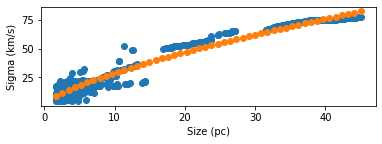

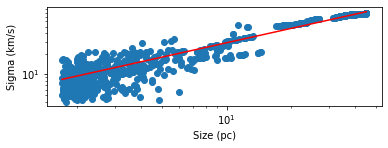

In [34]:
#CO


Num=3
Overlaps=2
Ram_Limiter=1#What percent of the cube my ram can handle
Name = "CO 3-2"
name = "CO_3_2_CM_Contours_DS_10.jpeg"
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
print(NameS)
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','HCN_J1-0.cube.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)
#Confidences = np.load('Confidence_data.npy')

#Noises = np.load('Noises_K.npy')
Noises = Ns
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]
print(Confidences[0],Confidences.shape,sc.hdu.data.shape)
BP = np.where(Confidences<Overlaps)#Overlaps)
sc.hdu.data[BP]=np.nan
print(sc.hdu.data[BP])
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

#cen_p1 = SkyCoord('00h47m33.6s', '-25d17m16.8s', frame='icrs')
#cen_p2 = SkyCoord('00h47m33.3s', '-25d17m14.2s', frame='icrs')

scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scn[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
raQDP1 = [int(scQW.world_to_pixel(cen_p1)[0]),int(scQW.world_to_pixel(cen_p1)[1])]
raQDP2 = [int(scQW.world_to_pixel(cen_p2)[0]),int(scQW.world_to_pixel(cen_p2)[1])]
scQF = scQn[:,raQDP1[1]:raQDP2[1],raQDP1[0]:raQDP2[0]] # Make a subcube
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

#Unload all the unimportant vars

del BP
del paths

d = astrodendro.Dendrogram.compute(datn,wcs=wcs,min_delta=m,min_value=m*5,min_npix=30) #The main culprit



header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['spatial_scale'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['spatial_scale']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
metadata["wcs"] = wcs
metadata["spectral_resolution"] = abs(header["CDELT3"])#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc
vel,NA,na = sc.world[:,0,0]

##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()
fig = plt.figure(1,figsize=(30,30))

scU = SpectralCube.read(path)  
scWU = scU.wcs[:][:][0]
raDP1U = [int(scWU.world_to_pixel(cen_p1)[0]),int(scWU.world_to_pixel(cen_p1)[1])]
raDP2U = [int(scWU.world_to_pixel(cen_p2)[0]),int(scWU.world_to_pixel(cen_p2)[1])]
scNU = scU[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),raDP1U[1]:raDP2U[1],raDP1U[0]:raDP2U[0]] # Make a subcube based on position
scWU = scNU.wcs[:][:][0]
#####
SC_KMSU = scNU.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMSU.allow_huge_operations=True
SC_K_KMSU = SC_KMSU.to(u.K)
SC_K_KMS_slabU = SC_K_KMSU.spectral_slab(-888. *u.km / u.s, 888. *u.km / u.s)  # Extract a subset of the velocities
ds=20
SC_CM = SC_K_KMS_slabU.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(5,5,n+1,projection=sc.wcs[:][:][0]) # We plot them in a grid    
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12) 
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        s = PPVStatistic(t)
        if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            k=0
            for ll in range(len(I[0])):
                if(I[0][ll] - int((n+.5)*ds) ==0):
                    k=int((n+.5)*ds)
                    break
            for ll in range(len(I[0])):
                if(k==int((n+.5)*ds)  and n!= 0):
                    break
                miN=3
                if(abs(I[0][ll] - int((n+.5)*ds)) <miN):
                    k=I[0][ll]
                    break
            if(k!=0):
                p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=.1,slice = k)
                ellipse = s.to_mpl_ellipse(edgecolor='pink', facecolor='pink',alpha=.1)
                ax.add_patch(ellipse)
            #print(t.indices())
            #break
if (noplot==False):
    fig.savefig(bbox_inches='tight',fname=name)


rads=np.array([])
sigmas=np.array([])
for t in d.all_structures: 
    
    I = t.indices()
    s = PPVStatistic(t)
        
    if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
        rads=np.append(rads,[(s.radius*metadata['spatial_scale']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc)]) #convert pixel to pc (then make it dimensionless)
        sigmas=np.append(sigmas,[(s.v_rms*metadata['spectral_resolution']/u.pix)])#Convert pixel to velocity (then make it dimensionless)


from scipy.optimize import curve_fit
print(np.shape(rads))
def func(R,a,b):
    return a*R**(b)
popt, pcov = curve_fit(func, rads*10**6, sigmas)
print(popt,pcov)
print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
fig = plt.figure()
ax = pylab.subplot(2, 1, 1)
xp1 = ax.scatter(rads*10**6,sigmas)
xs=np.linspace(np.nanmin(rads*10**6),np.nanmax(rads*10**6),50)
ys=func(xs,popt[0],popt[1])
xpa1 = ax.scatter(xs,ys)
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()
ax2 = pylab.subplot(2, 1, 2)
xp = ax2.scatter(rads*10**6,sigmas)
p = ax2.plot(xs,ys,c='red')
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()

np.save(NameS,sigmas)
np.save(NameR,rads)



NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits
0.817139116091404
[[0. 1. 1. ... 2. 1. 1.]
 [0. 2. 2. ... 2. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 2. 1.]
 [0. 0. 0. ... 1. 2. 1.]] (252, 400, 488) (252, 400, 488)
[nan nan nan ... nan nan nan]
(252, 400, 488) (252, 400, 488)
0.174999999999996 arcsec 0.174999999999996 arcsec
12.24999999999748 pix2
(122,)


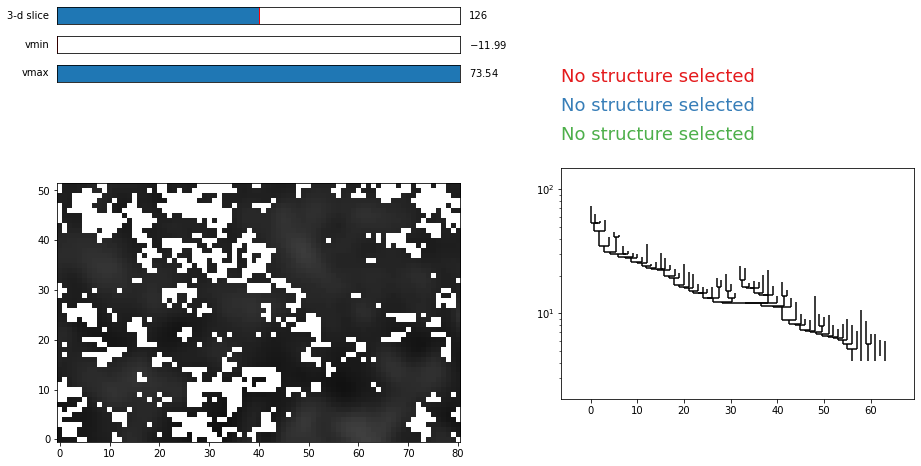

ValueError: num must be 1 <= num <= 25, not 26

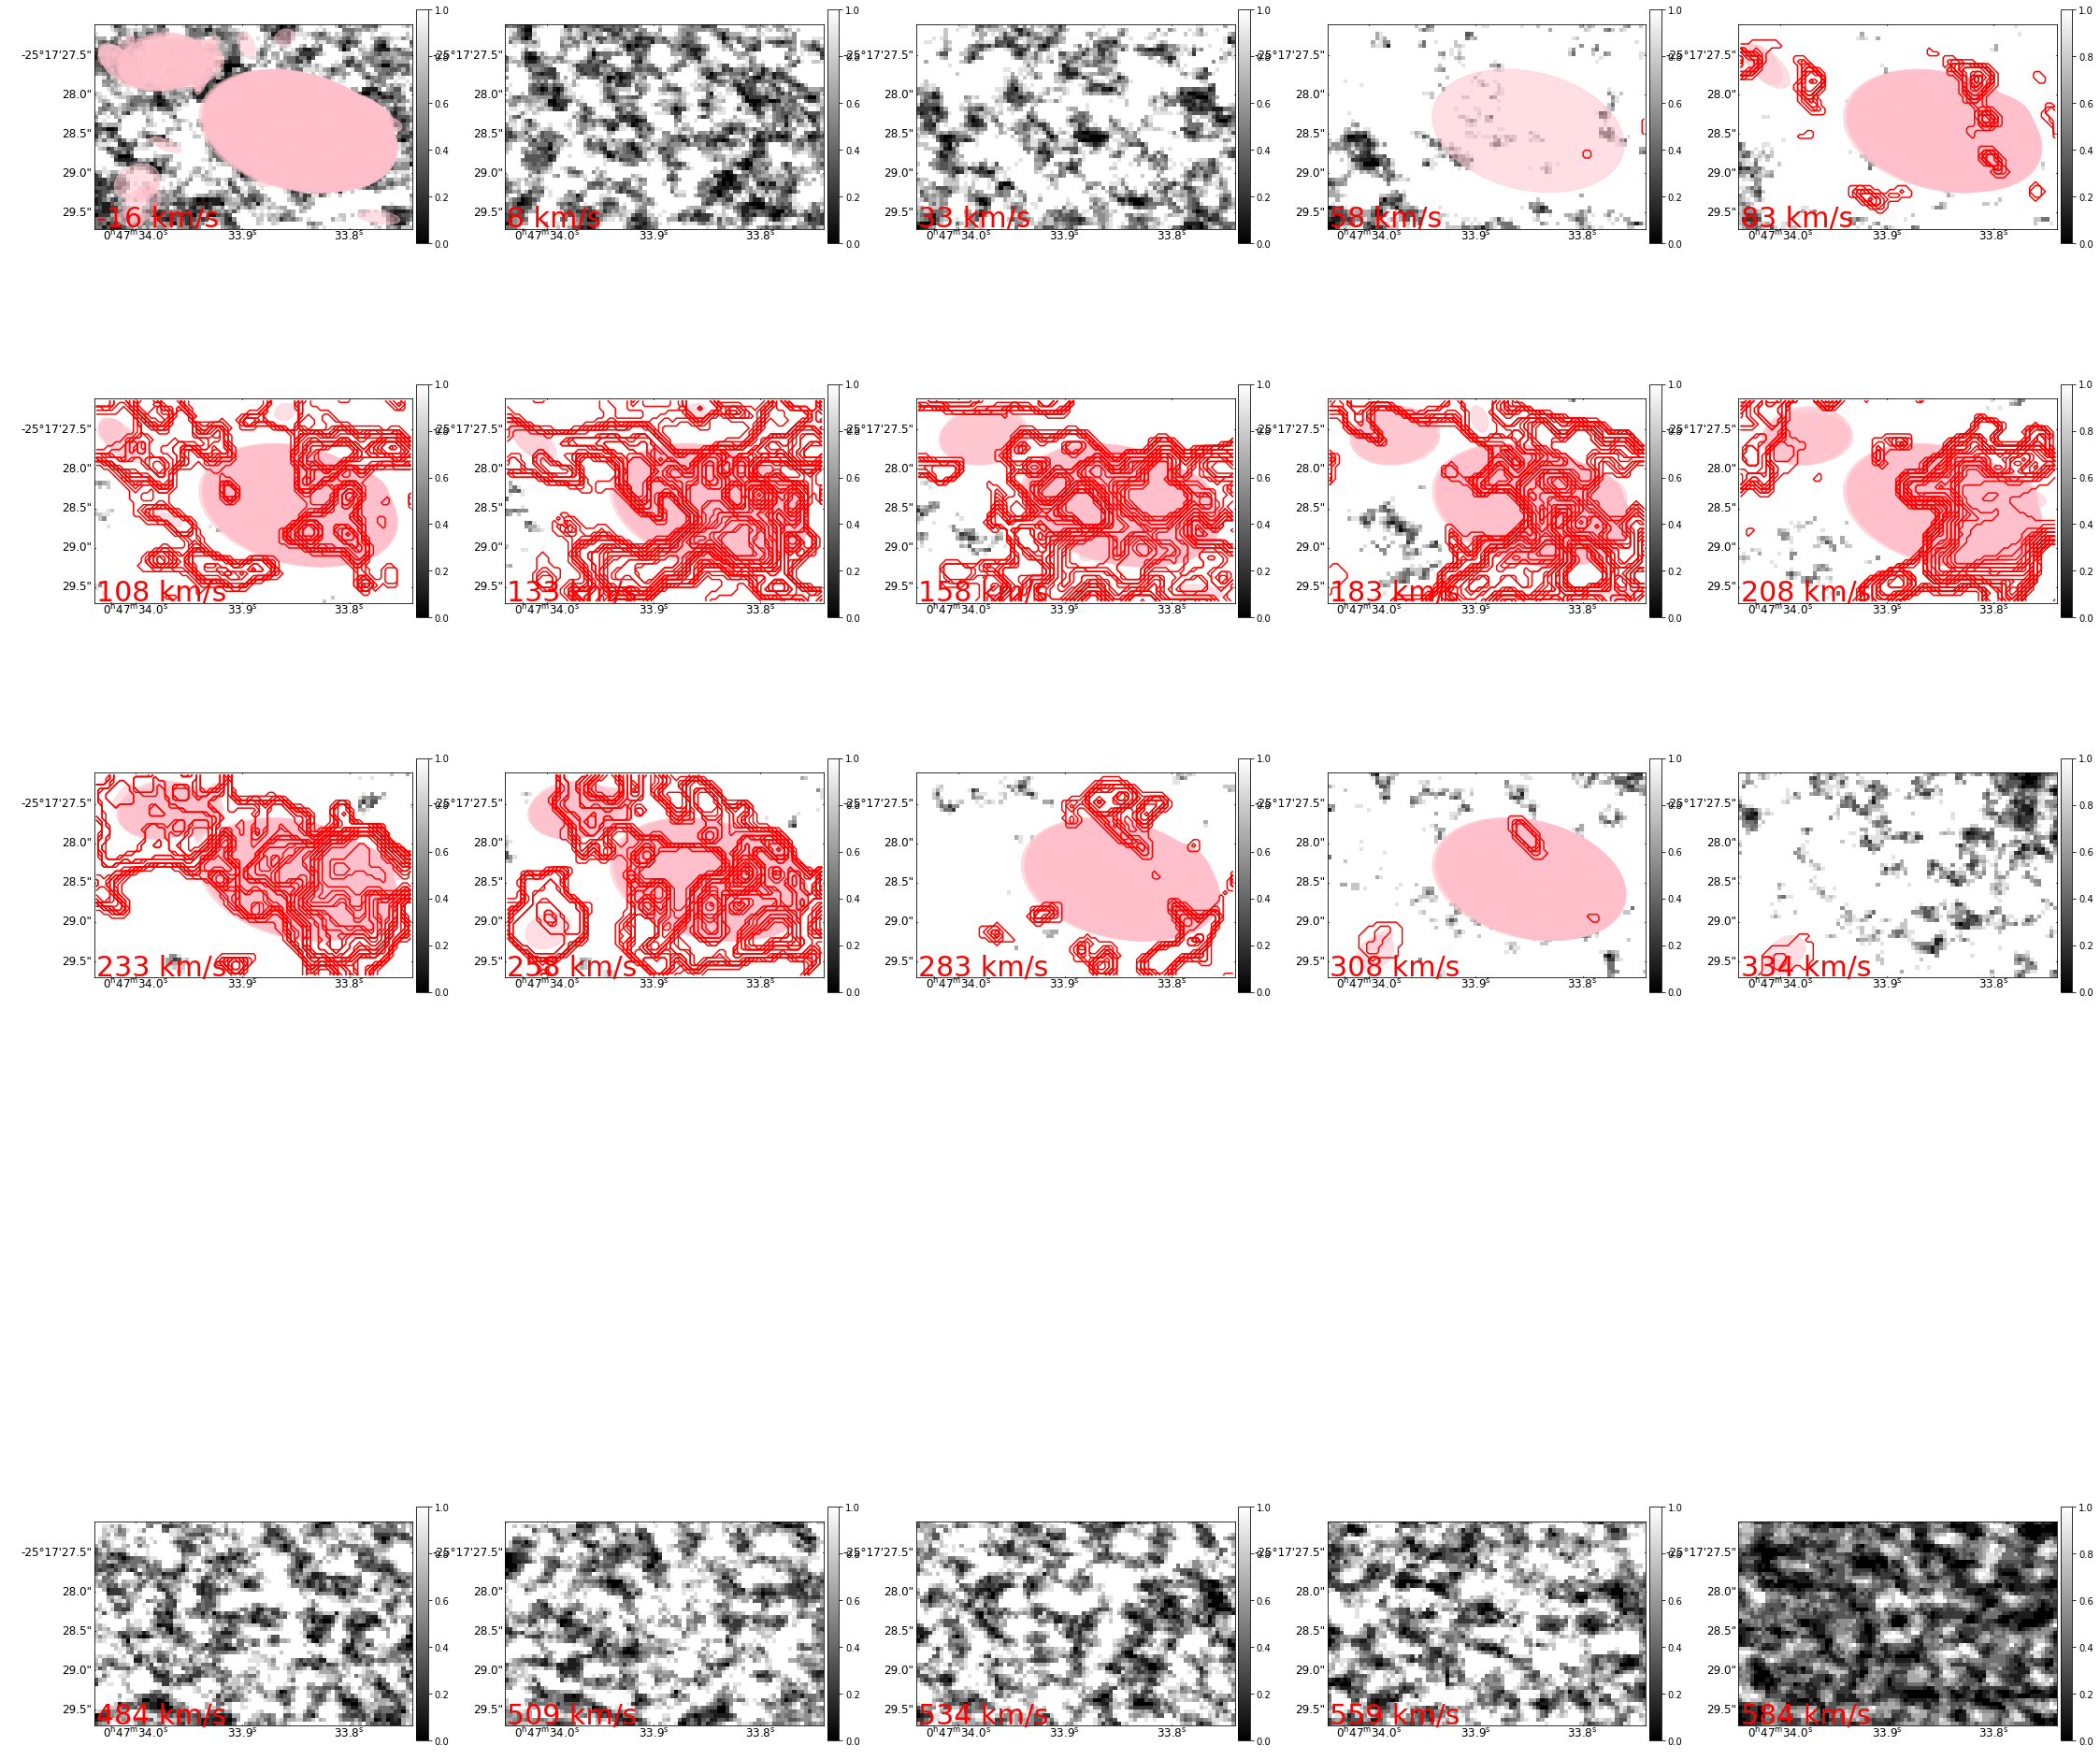

In [35]:
#CO


Num=3
Overlaps=2
Ram_Limiter=1#What percent of the cube my ram can handle
Name = "CO 3-2"
name = "CO_3_2_CM_Contours_DS_10.jpeg"
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','HCN_J1-0.cube.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)
#Confidences = np.load('Confidence_data.npy')

#Noises = np.load('Noises_K.npy')
Noises = Ns
m = Noises[Num]
print(m)
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]
print(Confidences[0],Confidences.shape,sc.hdu.data.shape)
BP = np.where(Confidences<Overlaps)#Overlaps)
sc.hdu.data[BP]=np.nan
print(sc.hdu.data[BP])
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
#cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
#cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

cen_p1 = SkyCoord('00h47m33.6s', '-25d17m16.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m33.3s', '-25d17m14.2s', frame='icrs')

scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
lc = Confidences[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scn[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
raQDP1 = [int(scQW.world_to_pixel(cen_p1)[0]),int(scQW.world_to_pixel(cen_p1)[1])]
raQDP2 = [int(scQW.world_to_pixel(cen_p2)[0]),int(scQW.world_to_pixel(cen_p2)[1])]
scQF = scQn[:,raQDP1[1]:raQDP2[1],raQDP1[0]:raQDP2[0]] # Make a subcube
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

#Unload all the unimportant vars

del BP
del paths

d = astrodendro.Dendrogram.compute(datn,wcs=wcs,min_delta=m,min_value=m*5,min_npix=30) #The main culprit



header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['spatial_scale'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['spatial_scale']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
metadata["wcs"] = wcs
metadata["spectral_resolution"] = abs(header["CDELT3"])#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc
vel,NA,na = sc.world[:,0,0]

##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()
fig = plt.figure(1,figsize=(30,30))

scU = SpectralCube.read(path)  
scWU = scU.wcs[:][:][0]
raDP1U = [int(scWU.world_to_pixel(cen_p1)[0]),int(scWU.world_to_pixel(cen_p1)[1])]
raDP2U = [int(scWU.world_to_pixel(cen_p2)[0]),int(scWU.world_to_pixel(cen_p2)[1])]
scNU = scU[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),raDP1U[1]:raDP2U[1],raDP1U[0]:raDP2U[0]] # Make a subcube based on position
scWU = scNU.wcs[:][:][0]
#####
SC_KMSU = scNU.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMSU.allow_huge_operations=True
SC_K_KMSU = SC_KMSU.to(u.K)
SC_K_KMS_slabU = SC_K_KMSU.spectral_slab(-888. *u.km / u.s, 888. *u.km / u.s)  # Extract a subset of the velocities
SC_CM = SC_K_KMS_slabU.downsample_axis(10,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM


for n in np.arange(0,len(SC_CM.hdu.data)):   
    
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(5,5,n+1,projection=sc.wcs[:][:][0]) # We plot them in a grid    
    #im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    im = pylab.imshow(np.nanmean(lc[n*10:10*n+9],axis=0),cmap='gray',vmin=0,vmax=1)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12) 
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        s = PPVStatistic(t)
        if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            k=0
            for ll in range(len(I[0])):
                if(I[0][ll] - n*10 ==0):
                    k=n*10
                    break
            for ll in range(len(I[0])):
                if(k==n*10):
                    break
                miN=2
                
                if(abs(I[0][ll] - n*10) <miN):
                    k=I[0][ll]
                    break
            if(k!=0 or (k==0 and n==0)):
                p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=1,slice = k)
                ellipse = s.to_mpl_ellipse(edgecolor='pink', facecolor='pink',alpha=.5)
                ax.add_patch(ellipse)
            #print(t.indices())
            #break


for t in d.all_structures: 
    
    I = t.indices()
    s = PPVStatistic(t)
        
    if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
        rads=np.append(rads,[(s.radius*metadata['spatial_scale']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc)]) #convert pixel to pc (then make it dimensionless)
        sigmas=np.append(sigmas,[(s.v_rms*metadata['spectral_resolution']/u.pix)])#Convert pixel to velocity (then make it dimensionless)


from scipy.optimize import curve_fit
print(np.shape(rads))
def func(R,a,b):
    return a*R**(b)
popt, pcov = curve_fit(func, rads*10**6, sigmas)
print(popt,pcov)
print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
fig = plt.figure()
ax = pylab.subplot(2, 1, 1)
xp1 = ax.scatter(rads*10**6,sigmas)
xs=np.linspace(np.nanmin(rads*10**6),np.nanmax(rads*10**6),50)
ys=func(xs,popt[0],popt[1])
xpa1 = ax.scatter(xs,ys)
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()
ax2 = pylab.subplot(2, 1, 2)
xp = ax2.scatter(rads*10**6,sigmas)
p = ax2.plot(xs,ys,c='red')
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()


CCHSigmas
CCH_N1.cube.reproject.K-kms.pbcor.fits
[[0. 1. 1. ... 2. 1. 1.]
 [0. 2. 2. ... 2. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 2. 1.]
 [0. 0. 0. ... 1. 2. 1.]] (252, 400, 488) (252, 400, 488)
[nan nan nan ... nan nan nan]
(252, 400, 488) (252, 400, 488)
0.205438002944004 arcsec 0.2807028591633 arcsec
23.066813922868455 pix2
(1244,)


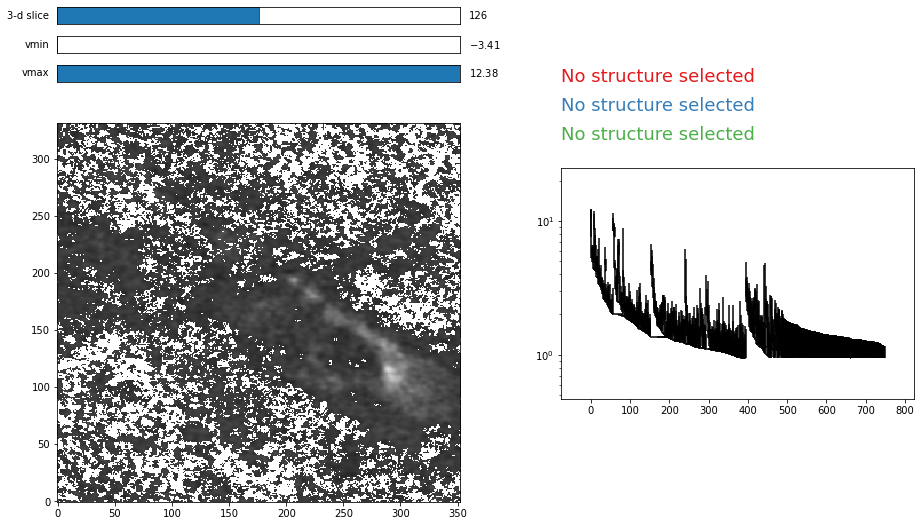

(515,)
[3.50302388 0.82900354] [[ 0.02430192 -0.00214881]
 [-0.00214881  0.00019314]]
a =  3.5030238788508328 +- 0.15589073469913245
b =  0.8290035413510137 +- 0.01389743627890948


<Figure size 2160x2160 with 0 Axes>

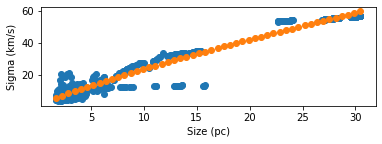

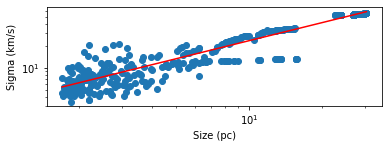

In [36]:
#CCH

Num = 6
Overlaps = 2
Ram_Limiter = 1
Name = "CCH"
name = "CCH_CM_Contours_DS_10.jpeg"
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
print(NameS)
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','HCN_J1-0.cube.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)
#Confidences = np.load('Confidence_data.npy')

#Noises = np.load('Noises_K.npy')
Noises = Ns
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]
print(Confidences[0],Confidences.shape,sc.hdu.data.shape)
BP = np.where(Confidences<Overlaps)#Overlaps)
sc.hdu.data[BP]=np.nan
print(sc.hdu.data[BP])
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

#cen_p1 = SkyCoord('00h47m33.6s', '-25d17m16.8s', frame='icrs')
#cen_p2 = SkyCoord('00h47m33.3s', '-25d17m14.2s', frame='icrs')

scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scn[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
raQDP1 = [int(scQW.world_to_pixel(cen_p1)[0]),int(scQW.world_to_pixel(cen_p1)[1])]
raQDP2 = [int(scQW.world_to_pixel(cen_p2)[0]),int(scQW.world_to_pixel(cen_p2)[1])]
scQF = scQn[:,raQDP1[1]:raQDP2[1],raQDP1[0]:raQDP2[0]] # Make a subcube
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

#Unload all the unimportant vars

del BP
del paths

d = astrodendro.Dendrogram.compute(datn,wcs=wcs,min_delta=m,min_value=m*5,min_npix=30) #The main culprit



header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['spatial_scale'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['spatial_scale']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
metadata["wcs"] = wcs
metadata["spectral_resolution"] = abs(header["CDELT3"])#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc
vel,NA,na = sc.world[:,0,0]

##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()
fig = plt.figure(1,figsize=(30,30))

scU = SpectralCube.read(path)  
scWU = scU.wcs[:][:][0]
raDP1U = [int(scWU.world_to_pixel(cen_p1)[0]),int(scWU.world_to_pixel(cen_p1)[1])]
raDP2U = [int(scWU.world_to_pixel(cen_p2)[0]),int(scWU.world_to_pixel(cen_p2)[1])]
scNU = scU[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),raDP1U[1]:raDP2U[1],raDP1U[0]:raDP2U[0]] # Make a subcube based on position
scWU = scNU.wcs[:][:][0]
#####
SC_KMSU = scNU.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMSU.allow_huge_operations=True
SC_K_KMSU = SC_KMSU.to(u.K)
SC_K_KMS_slabU = SC_K_KMSU.spectral_slab(-888. *u.km / u.s, 888. *u.km / u.s)  # Extract a subset of the velocities
ds=20
SC_CM = SC_K_KMS_slabU.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(5,5,n+1,projection=sc.wcs[:][:][0]) # We plot them in a grid    
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12) 
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        s = PPVStatistic(t)
        if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            k=0
            for ll in range(len(I[0])):
                if(I[0][ll] - int((n+.5)*ds) ==0):
                    k=int((n+.5)*ds)
                    break
            for ll in range(len(I[0])):
                if(k==int((n+.5)*ds)  and n!= 0):
                    break
                miN=3
                if(abs(I[0][ll] - int((n+.5)*ds)) <miN):
                    k=I[0][ll]
                    break
            if(k!=0):
                p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=.1,slice = k)
                ellipse = s.to_mpl_ellipse(edgecolor='pink', facecolor='pink',alpha=.1)
                ax.add_patch(ellipse)
            #print(t.indices())
            #break
if (noplot==False):
    fig.savefig(bbox_inches='tight',fname=name)


rads=np.array([])
sigmas=np.array([])
for t in d.all_structures: 
    
    I = t.indices()
    s = PPVStatistic(t)
        
    if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
        rads=np.append(rads,[(s.radius*metadata['spatial_scale']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc)]) #convert pixel to pc (then make it dimensionless)
        sigmas=np.append(sigmas,[(s.v_rms*metadata['spectral_resolution']/u.pix)])#Convert pixel to velocity (then make it dimensionless)


from scipy.optimize import curve_fit
print(np.shape(rads))
def func(R,a,b):
    return a*R**(b)
popt, pcov = curve_fit(func, rads*10**6, sigmas)
print(popt,pcov)
print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
fig = plt.figure()
ax = pylab.subplot(2, 1, 1)
xp1 = ax.scatter(rads*10**6,sigmas)
xs=np.linspace(np.nanmin(rads*10**6),np.nanmax(rads*10**6),50)
ys=func(xs,popt[0],popt[1])
xpa1 = ax.scatter(xs,ys)
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()
ax2 = pylab.subplot(2, 1, 2)
xp = ax2.scatter(rads*10**6,sigmas)
p = ax2.plot(xs,ys,c='red')
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()

np.save(NameS,sigmas)
np.save(NameR,rads)



HC3NSigmas
HC3N_J11.cube.reproject.K-kms.pbcor.fits
[[0. 1. 1. ... 2. 1. 1.]
 [0. 2. 2. ... 2. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 2. 1.]
 [0. 0. 0. ... 1. 2. 1.]] (252, 400, 488) (252, 400, 488)
[nan nan nan ... nan nan nan]
(252, 400, 488) (252, 400, 488)
0.1598673317904 arcsec 0.225428467502556 arcsec
14.415459043690701 pix2
(74,)


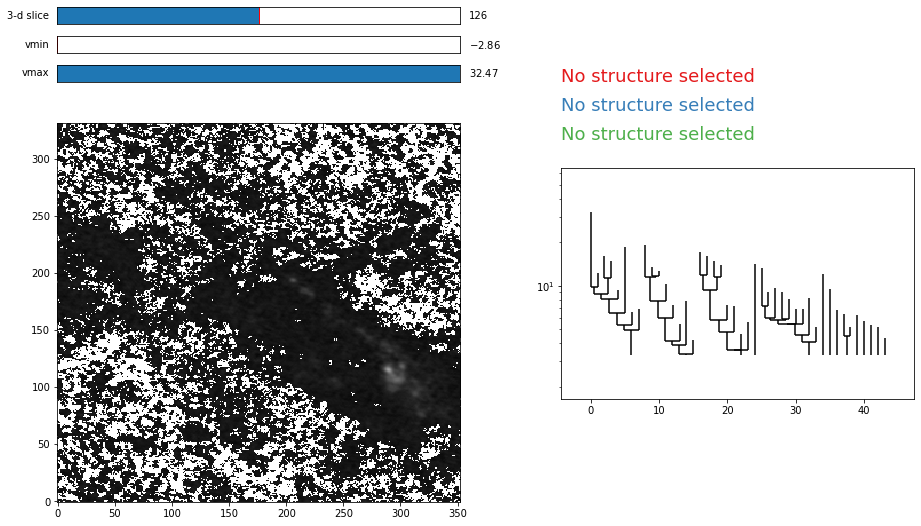

(37,)
[7.11978939 0.5363859 ] [[ 0.93280013 -0.07539674]
 [-0.07539674  0.00654696]]
a =  7.1197893885080905 +- 0.9658157835956821
b =  0.536385896505949 +- 0.08091326406774155


<Figure size 2160x2160 with 0 Axes>

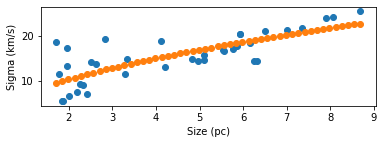

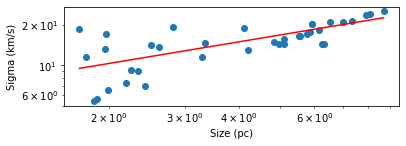

In [37]:
#HC3N
Num = 7
Overlaps = 2
Ram_Limiter = 1
Name = "HC3N"
name = "HC3N_CM_Contours_DS_10.jpeg"
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
print(NameS)
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','HCN_J1-0.cube.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)
#Confidences = np.load('Confidence_data.npy')

#Noises = np.load('Noises_K.npy')
Noises = Ns
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]
print(Confidences[0],Confidences.shape,sc.hdu.data.shape)
BP = np.where(Confidences<Overlaps)#Overlaps)
sc.hdu.data[BP]=np.nan
print(sc.hdu.data[BP])
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

#cen_p1 = SkyCoord('00h47m33.6s', '-25d17m16.8s', frame='icrs')
#cen_p2 = SkyCoord('00h47m33.3s', '-25d17m14.2s', frame='icrs')

scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scn[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
raQDP1 = [int(scQW.world_to_pixel(cen_p1)[0]),int(scQW.world_to_pixel(cen_p1)[1])]
raQDP2 = [int(scQW.world_to_pixel(cen_p2)[0]),int(scQW.world_to_pixel(cen_p2)[1])]
scQF = scQn[:,raQDP1[1]:raQDP2[1],raQDP1[0]:raQDP2[0]] # Make a subcube
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

#Unload all the unimportant vars

del BP
del paths

d = astrodendro.Dendrogram.compute(datn,wcs=wcs,min_delta=m,min_value=m*5,min_npix=30) #The main culprit



header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['spatial_scale'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['spatial_scale']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
metadata["wcs"] = wcs
metadata["spectral_resolution"] = abs(header["CDELT3"])#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc
vel,NA,na = sc.world[:,0,0]

##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()
fig = plt.figure(1,figsize=(30,30))

scU = SpectralCube.read(path)  
scWU = scU.wcs[:][:][0]
raDP1U = [int(scWU.world_to_pixel(cen_p1)[0]),int(scWU.world_to_pixel(cen_p1)[1])]
raDP2U = [int(scWU.world_to_pixel(cen_p2)[0]),int(scWU.world_to_pixel(cen_p2)[1])]
scNU = scU[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),raDP1U[1]:raDP2U[1],raDP1U[0]:raDP2U[0]] # Make a subcube based on position
scWU = scNU.wcs[:][:][0]
#####
SC_KMSU = scNU.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMSU.allow_huge_operations=True
SC_K_KMSU = SC_KMSU.to(u.K)
SC_K_KMS_slabU = SC_K_KMSU.spectral_slab(-888. *u.km / u.s, 888. *u.km / u.s)  # Extract a subset of the velocities
ds=20
SC_CM = SC_K_KMS_slabU.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(5,5,n+1,projection=sc.wcs[:][:][0]) # We plot them in a grid    
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12) 
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        s = PPVStatistic(t)
        if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            k=0
            for ll in range(len(I[0])):
                if(I[0][ll] - int((n+.5)*ds) ==0):
                    k=int((n+.5)*ds)
                    break
            for ll in range(len(I[0])):
                if(k==int((n+.5)*ds)  and n!= 0):
                    break
                miN=3
                if(abs(I[0][ll] - int((n+.5)*ds)) <miN):
                    k=I[0][ll]
                    break
            if(k!=0):
                p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=.1,slice = k)
                ellipse = s.to_mpl_ellipse(edgecolor='pink', facecolor='pink',alpha=.1)
                ax.add_patch(ellipse)
            #print(t.indices())
            #break
if (noplot==False):
    fig.savefig(bbox_inches='tight',fname=name)


rads=np.array([])
sigmas=np.array([])
for t in d.all_structures: 
    
    I = t.indices()
    s = PPVStatistic(t)
        
    if(s.v_rms>1*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
        rads=np.append(rads,[(s.radius*metadata['spatial_scale']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc)]) #convert pixel to pc (then make it dimensionless)
        sigmas=np.append(sigmas,[(s.v_rms*metadata['spectral_resolution']/u.pix)])#Convert pixel to velocity (then make it dimensionless)


from scipy.optimize import curve_fit
print(np.shape(rads))
def func(R,a,b):
    return a*R**(b)
popt, pcov = curve_fit(func, rads*10**6, sigmas)
print(popt,pcov)
print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
fig = plt.figure()
ax = pylab.subplot(2, 1, 1)
xp1 = ax.scatter(rads*10**6,sigmas)
xs=np.linspace(np.nanmin(rads*10**6),np.nanmax(rads*10**6),50)
ys=func(xs,popt[0],popt[1])
xpa1 = ax.scatter(xs,ys)
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()
ax2 = pylab.subplot(2, 1, 2)
xp = ax2.scatter(rads*10**6,sigmas)
p = ax2.plot(xs,ys,c='red')
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()

np.save(NameS,sigmas)
np.save(NameR,rads)

